<a href="https://colab.research.google.com/github/Rene-HN/Churn-Uplift-Model/blob/main/KKbox_Churn_Uplift_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Second Capstone Project
## KKBox's Churn Prediction Challenge

>In this challenge, we were asked to predict whether a user will churn after his/her subscription expires. Specifically, we want to forecast if a user make a new service subscription transaction within 30 days after the current membership expiration date.

>KKBOX offers subscription based music streaming service. When users signs up for our service, users can choose to either manual renew or auto-renew the service. Users can actively cancel their membership at any time.

>The churn/renewal definition can be tricky due to KKBox's subscription model. Since the majority of KKBox's subscription length is 30 days, a lot of users re-subscribe every month. The key fields to determine churn/renewal are transaction date, membership expiration date, and is_cancel. Note that the is_cancel field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.

### Tables
1. ***train.csv***

>the train set, containing the user ids and whether they have churned.

* msno: user id
* is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

2. ***train_v2.csv***


>same format as sample_submission_zero.csv, refreshed 11/06/2017, contains the test data for April, 2017.

3. ***transactions.csv***

>transactions of users up until 2/28/2017.

* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction.

4. ***transactions_v2.csv***

>same format as transactions.csv, refreshed 11/06/2017, contains the transactions data until 3/31/2017.

5. ***user_logs.csv***

>daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song length
* num_50: # of songs played between 25% to 50% of the song length
* num_75: # of songs played between 50% to 75% of of the song length
* num_985: # of songs played between 75% to 98.5% of the song length
* num_100: # of songs played over 98.5% of the song length
* num_unq: # of unique songs played
* total_secs: total seconds played

6. ***user_logs_v2.csv***

>same format as user_logs.csv, refreshed 11/06/2017, contains the user logs data until 3/31/2017.

7. ***members.csv***

>user information. Note that not every user in the dataset is available.

* msno
* city
* bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

8. ***members_v3.csv***

>Refreshed 11/13/2017, replaces members.csv data with the expiration date data removed.

In [ ]:
# # Change your working directory to where the data resides1Q
import os
os.chdir('/home/reneh/Capstone2 b/Data')
import pandas as pd
import numpy as np
import seaborn as sns
import dask
import dask.dataframe as dd
import xgboost as xgb
import dask_ml
from dask_ml.preprocessing import Categorizer, DummyEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import *
from matplotlib import pyplot as plt
import data_prep
%matplotlib inline

pd.options.display.max_columns= None
pd.options.display.max_rows = None

pd.options.display.width=None

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=12)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:45793' processes=1 threads=12, memory=33.65 GB>

## Inital Data Preparation

### Train and Test separation.
To avoid data leakage, we will start by separating the records that belongs to the test and train sets. 

In [ ]:
from sklearn.model_selection import train_test_split

trainfull_df = pd.read_csv('train_v2 .csv')


X = trainfull_df['msno']
y=trainfull_df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(  X, y, test_size=0.20)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train = pd.DataFrame(X_train)
X_train.to_parquet('X_train.parquet.gzip', engine='pyarrow', compression='gzip')
X_test = pd.DataFrame(X_test)
X_test.to_parquet('X_test.parquet.gzip', engine='pyarrow', compression='gzip')
y_train = pd.DataFrame(y_train)
y_train.to_parquet('y_train.parquet.gzip', engine='pyarrow', compression='gzip')
y_test = pd.DataFrame(y_test)
y_test.to_parquet('y_test.parquet.gzip', engine='pyarrow', compression='gzip')

In [ ]:
%%time
transactions_df = dd.read_csv('transactions.csv', blocksize=50e6)
transactions_v2_df = dd.read_csv('transactions_v2.csv', blocksize=50e6)
transactions_df = dd.concat([transactions_df, transactions_v2_df])
train_transactions_full_df = transactions_df.merge(X_train,on='msno')
train_transactions_agg= train_transactions_full_df.pipe(data_prep.trans_to_datetime).pipe(data_prep.new_transaction_features).pipe(data_prep.transaction_group_agg)
train_transactions_agg.to_parquet('train_transactions_agg.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 2.69 s, sys: 327 ms, total: 3.02 s
Wall time: 1min 27s


In [ ]:
%%time
X_test = pd.read_parquet('X_test.parquet.gzip', engine='pyarrow')
X_test = pd.DataFrame(X_test)
transactions_df = dd.read_csv('transactions.csv', blocksize=50e6)
transactions_v2_df = dd.read_csv('transactions_v2.csv', blocksize=50e6)
transactions_df = dd.concat([transactions_df, transactions_v2_df])
test_transactions_full_df = transactions_df.merge(X_test,on='msno')
test_transactions_agg = test_transactions_full_df.pipe(data_prep.trans_to_datetime).pipe(data_prep.new_transaction_features).pipe(data_prep.transaction_group_agg)
test_transactions_agg.to_parquet('test_transactions_agg.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 1.12 s, sys: 114 ms, total: 1.23 s
Wall time: 32.9 s


In [ ]:
%%time
user_logs_ddf = dd.read_csv('user_logs.csv', blocksize=250e6)
user_logs_v2_ddf = dd.read_csv('user_logs_v2.csv', blocksize=250e6)
user_logs_ddf = dd.concat([user_logs_ddf, user_logs_v2_ddf])
X_train = dd.read_parquet('X_train.parquet.gzip', chunksize=25)

CPU times: user 37 ms, sys: 0 ns, total: 37 ms
Wall time: 46.7 ms


In [ ]:
%%time
train_user_logs_ddf = user_logs_ddf.merge(X_train, on='msno')
train_user_logs_ddf
train_logs_agg = train_user_logs_ddf.pipe(data_prep.new_log_features).pipe(data_prep.log_to_datetime).pipe(data_prep.log_group_agg)
train_logs_agg.to_parquet('train_logs_agg.parquet.gzip', engine='pyarrow', compression='gzip') 

CPU times: user 1min 2s, sys: 3.95 s, total: 1min 6s
Wall time: 8min 37s


In [ ]:
%%time
user_logs_ddf = dd.read_csv('user_logs.csv', blocksize=250e6)
user_logs_v2_ddf = dd.read_csv('user_logs_v2.csv', blocksize=250e6)
user_logs_ddf = dd.concat([user_logs_ddf, user_logs_v2_ddf])
X_test = dd.read_parquet('X_test.parquet.gzip', chunksize=25)
test_user_logs_ddf = user_logs_ddf.merge(X_test, on='msno')
test_logs_agg = test_user_logs_ddf.pipe(data_prep.new_log_features).pipe(data_prep.log_to_datetime).pipe(data_prep.log_group_agg)
test_logs_agg.to_parquet('test_logs_agg.parquet.gzip', engine='pyarrow', compression='gzip') 

CPU times: user 39.3 s, sys: 2.07 s, total: 41.3 s
Wall time: 4min 18s


In [ ]:
%%time
members_v3_df = dd.read_csv('members_v3.csv', blocksize=250e6)

CPU times: user 59.5 ms, sys: 4.05 ms, total: 63.5 ms
Wall time: 60.3 ms


In [ ]:
%%time
test_transaction_ddf = dd.read_parquet('test_transactions_agg.parquet.gzip', engine='pyarrow', chunksize=25)
test_logs_ddf = dd.read_parquet('test_logs_agg.parquet.gzip', engine='pyarrow', chunksize=25)

CPU times: user 32.9 ms, sys: 42 µs, total: 32.9 ms
Wall time: 32.2 ms


In [ ]:
%%time
def members_merge(ddf1, ddf2, ddf3):
    ddf = dd.merge(ddf1, ddf2, on='msno')
    ddf = dd.merge(ddf, ddf3, on='msno')
    return ddf

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [ ]:
%%time
def members_to_timedate(ddf):
    ddf["registration_init_time"]= dd.to_datetime( ddf["registration_init_time"], format='%Y%m%d', errors='coerce')
    ddf["registration_init_year"]=  ddf["registration_init_time"].dt.year
    ddf["registration_init_month"]=  ddf["registration_init_time"].dt.month
    ddf["registration_init_day"]=  ddf["registration_init_time"].dt.day
    ddf["max_transaction_year"]=  ddf["max_transaction_date"].dt.year
    ddf["max_transaction_month"]=  ddf["max_transaction_date"].dt.month
    ddf["max_transaction_day"]=  ddf["max_transaction_date"].dt.day
    ddf["account_age"]=  ddf["max_transaction_date"].dt.year -  ddf["registration_init_time"].dt.year
    return ddf

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [ ]:
%%time
test_ddf = members_merge(members_v3_df, test_transaction_ddf, test_logs_ddf ).pipe(members_to_timedate)

CPU times: user 118 ms, sys: 113 µs, total: 118 ms
Wall time: 116 ms


In [ ]:
%%time
test_ddf.to_parquet('test_members_logs_trans.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 721 ms, sys: 39.1 ms, total: 760 ms
Wall time: 14.7 s


In [ ]:
%%time
train_transaction_ddf = dd.read_parquet('train_transactions_agg.parquet.gzip', engine='pyarrow', chunksize=25)
train_logs_ddf = dd.read_parquet('train_logs_agg.parquet.gzip', engine='pyarrow', chunksize=25)

CPU times: user 24.3 ms, sys: 10.7 ms, total: 35 ms
Wall time: 46.9 ms


In [ ]:
%%time
train_ddf = members_merge(members_v3_df, train_transaction_ddf, train_logs_ddf ).pipe(members_to_timedate)

CPU times: user 130 ms, sys: 146 µs, total: 131 ms
Wall time: 128 ms


In [ ]:
%%time
train_ddf.to_parquet('train_members_logs_trans.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 1.56 s, sys: 95.3 ms, total: 1.65 s
Wall time: 37.2 s


In [ ]:
%%time
train_ddf.head()

CPU times: user 426 ms, sys: 16.4 ms, total: 442 ms
Wall time: 8.76 s


msno  city  bd  gender  \
0  +tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=     1   0     NaN   
1  yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=     4  30    male   
2  I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=    13  63    male   
3  OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=     1   0     NaN   
4  4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=     4  28  female   

   registered_via registration_init_time  min_payment_id  max_payment_id  \
0               7             2011-09-14              41              41   
1               9             2011-09-16              39              39   
2               9             2011-09-18              40              40   
3               7             2011-09-18              41              41   
4               9             2011-09-20              31              36   

   mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
0             41.0        0.000000            1230              0   
1             39.0        0.000000             819              0   
2             40.0        0.000000            1080              0   
3             41.0        0.000000            1107              0   
4             35.0        2.108185             350              0   

   max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
0             30       29.000000       5.477226            870   
1             31       28.714286       6.588952            603   
2             31       29.000000       5.804508            783   
3             30       28.888889       5.773503            780   
4             30       27.000000       9.486833            270   

   min_price_list  max_price_list  mean_price_list  std_price_list  \
0               0             149       132.700000       26.929218   
1               0             149       141.904762       32.514466   
2               0             149       143.481481       28.675063   
3               0             149       143.481481       28.675063   
4               0             180       158.900000       56.675391   

   sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
0            3981              129              149        137.666667   
1            2980              149              149        149.000000   
2            3874              149              149        149.000000   
3            3874              149              149        149.000000   
4            1589              149              180        173.800000   

   std_amount_paid  sum_amount_paid  max_renew  count_renew  \
0        10.080139             4130          1           30   
1         0.000000             3129          1           21   
2         0.000000             4023          1           27   
3         0.000000             4023          1           27   
4        13.070748             1738          1           10   

  min_transaction_date max_transaction_date  count_transaction_date  \
0           2015-01-03           2017-03-27                      30   
1           2015-02-17           2017-03-31                      21   
2           2015-01-27           2017-03-27                      27   
3           2015-01-26           2017-03-26                      27   
4           2015-03-31           2017-03-03                      10   

  min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
0      2015-02-04      2017-04-28              1               30   
1      2015-03-17      2017-05-17              0               21   
2      2015-02-26      2017-04-26              0               27   
3      2015-02-27      2017-04-27              0               27   
4      2015-04-30      2017-04-02              1               10   

   max_auto_renew_&_cancel  count_auto_renew_&_cancel  min_days_to_expire  \
0                        1                         30                -334   
1                        0                         21                -319   
2                        0                     

## Exploratory Data Analisys

In [ ]:
# # Change your working directory to where the data resides1Q
import os
os.chdir('/home/reneh/Capstone2 b/Data')
import pandas as pd
import numpy as np
import seaborn as sns
import dask
import dask.dataframe as dd
import xgboost as xgb

from dask_ml.preprocessing import Categorizer, DummyEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import *
from matplotlib import pyplot as plt
import data_prep
%matplotlib inline

pd.options.display.max_columns= None
pd.options.display.max_rows = None

pd.options.display.width=None

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=16)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:42035' processes=1 threads=16, memory=33.65 GB>

In [ ]:
y_train = dd.read_parquet('y_train.parquet.gzip', engine='pyarrow')
y_train.head()

is_churn
314627         0
737389         0
402746         0
608704         1
550359         0

<AxesSubplot:xlabel='is_churn', ylabel='count'>

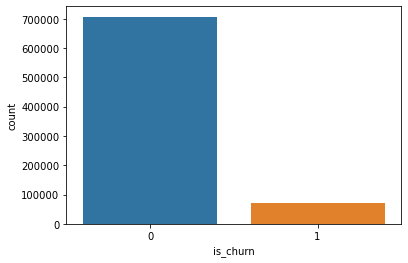

In [ ]:
sns.countplot(x=y_train['is_churn'].compute())

The above visualization confirms that we are dealing  with an imbalance clasification task.

Because the class distribution is not balanced, most machine learning algorithms will perform
poorly and require modification to avoid simply predicting the majority class in all cases.
Additionally, metrics like classification accuracy lose their meaning and alternate methods for
evaluating predictions on imbalanced examples are required, like churn uplift. This is
the foundational challenge of imbalanced classification.


In [ ]:

%%time
X_train = dd.read_parquet('X_train.parquet.gzip', engine = 'pyarrow')
#read from parquet in case kernel needs to restart.

CPU times: user 6.8 ms, sys: 407 µs, total: 7.21 ms
Wall time: 19.9 ms


In [ ]:
%%time
X_train.head()

CPU times: user 76.8 ms, sys: 11.2 ms, total: 88 ms
Wall time: 578 ms


msno
314627  aDOED6BbgIO0HlXRV+qlo9FZOAlm+gFme0CQ3RZYx5o=
737389  s2KLUnBmSnmVERJyy77lDtPhcFcqACPf3Z9TdboJMKg=
402746  eyFYmW7iBatPas8WrCaw3TwKTEVdpK2RmGry0exSbmE=
608704  1RUcYrJEg3qjKdQg1nxI6rjBYOQFitSurNHKskzMfDw=
550359  yuE0Hpf+5I3reaObxA1sdieQ9fct4hqxdxqQuwikvU4=

In [ ]:
%%time
X_train = X_train.merge(dd.read_parquet('y_train.parquet.gzip', engine='pyarrow'),left_index=True, right_index=True)
X_train.head()

CPU times: user 43.3 ms, sys: 5.63 ms, total: 48.9 ms
Wall time: 571 ms


msno  is_churn
314627  aDOED6BbgIO0HlXRV+qlo9FZOAlm+gFme0CQ3RZYx5o=         0
737389  s2KLUnBmSnmVERJyy77lDtPhcFcqACPf3Z9TdboJMKg=         0
402746  eyFYmW7iBatPas8WrCaw3TwKTEVdpK2RmGry0exSbmE=         0
608704  1RUcYrJEg3qjKdQg1nxI6rjBYOQFitSurNHKskzMfDw=         1
550359  yuE0Hpf+5I3reaObxA1sdieQ9fct4hqxdxqQuwikvU4=         0

In [ ]:
%%time
X_train = X_train.merge(dd.read_parquet('train_members_logs_trans.parquet.gzip', engine='pyarrow'), on='msno')
X_train

CPU times: user 55.3 ms, sys: 1.25 ms, total: 56.5 ms
Wall time: 55.2 ms


Dask DataFrame Structure:
                 msno is_churn   city     bd  gender registered_via registration_init_time min_payment_id max_payment_id mean_payment_id std_payment_id sum_payment_id min_plan_days max_plan_days mean_plan_days std_plan_days sum_plan_days min_price_list max_price_list mean_price_list std_price_list sum_price_list min_amount_paid max_amount_paid mean_amount_paid std_amount_paid sum_amount_paid max_renew count_renew min_transaction_date max_transaction_date count_transaction_date min_expire_date max_expire_date max_is_cancel count_is_cancel max_auto_renew_&_cancel count_auto_renew_&_cancel min_days_to_expire max_days_to_expire mean_days_to_expire std_days_to_expire sum_days_to_expire min_unpaid max_unpaid mean_unpaid std_unpaid sum_unpaid min_pmethod_renew max_pmethod_renew mean_pmethod_renew std_pmethod_renew sum_pmethod_renew        min_date        max_date count_date min_num_25 max_num_25 mean_num_25 std_num_25 sum_num_25 min_num_50 max_num_50 mean_num_50 std_num_50 sum_num_50 min_num_75 max_num_75 mean_num_75 std_num_75 sum_num_75 min_num_985 max_num_985 mean_num_985 std_num_985 sum_num_985 min_num_100 max_num_100 mean_num_100 std_num_100 sum_num_100 min_num_unq max_num_unq mean_num_unq std_num_unq sum_num_unq min_total_secs max_total_secs mean_total_secs std_total_secs sum_total_secs min_skip_ratio max_skip_ratio mean_skip_ratio std_skip_ratio sum_skip_ratio min_skip25_ratio max_skip25_ratio mean_skip25_ratio std_skip25_ratio sum_skip25_ratio min_skip50_ratio max_skip50_ratio mean_skip50_ratio std_skip50_ratio sum_skip50_ratio min_skip75_ratio max_skip75_ratio mean_skip75_ratio std_skip75_ratio sum_skip75_ratio min_skip985_ratio max_skip985_ratio mean_skip985_ratio std_skip985_ratio sum_skip985_ratio min_num100_ratio max_num100_ratio mean_num100_ratio std_num100_ratio sum_num100_ratio min_unq_ratio max_unq_ratio mean_unq_ratio std_unq_ratio sum_unq_ratio min_unq_secs_ratio max_unq_secs_ratio mean_unq_secs_ratio std_unq_secs_ratio sum_unq_secs_ratio min_num100_secs_ratio max_num100_secs_ratio mean_num100_secs_ratio std_num100_secs_ratio sum_num100_secs_ratio min_skip_secs_ratio max_skip_secs_ratio mean_skip_secs_ratio std_skip_secs_ratio sum_skip_secs_ratio min_skip25_secs_ratio max_skip25_secs_ratio mean_skip25_secs_ratio std_skip25_secs_ratio sum_skip25_secs_ratio min_skip50_secs_ratio max_skip50_secs_ratio mean_skip50_secs_ratio std_skip50_secs_ratio sum_skip50_secs_ratio min_skip75_secs_ratio max_skip75_secs_ratio mean_skip75_secs_ratio std_skip75_secs_ratio sum_skip75_secs_ratio min_skip985_secs_ratio max_skip985_secs_ratio mean_skip985_secs_ratio std_skip985_secs_ratio sum_skip985_secs_ratio min_daily_listening_ratio max_daily_listening_ratio mean_daily_listening_ratio std_daily_listening_ratio sum_daily_listening_ratio registration_init_year registration_init_month registration_init_day max_transaction_year max_transaction_month max_transaction_day account_age
npartitions=2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
%%time
X_train.head()

CPU times: user 234 ms, sys: 39.3 ms, total: 273 ms
Wall time: 7.2 s


msno  is_churn  city  bd  gender  \
0  s2KLUnBmSnmVERJyy77lDtPhcFcqACPf3Z9TdboJMKg=         0    15  25  female   
1  yuE0Hpf+5I3reaObxA1sdieQ9fct4hqxdxqQuwikvU4=         0     1   0    None   
2  m5N/tmBpDofVGRpot3/JtvXhNcVCYsqffx4+wCo8rKg=         0    10  43  female   
3  lt71xX4ujO70gJKEz05NqYqVyxqLu3cgM6QuY6DLaAU=         1    10  28    male   
4  4jufX4wMkRMrkWLu2K8EiRd0/fMQUD1PLbnISk2NzQI=         0    22  28    male   

   registered_via registration_init_time  min_payment_id  max_payment_id  \
0               9             2011-04-12              39              39   
1               7             2016-04-25              41              41   
2               9             2011-07-16              31              31   
3               9             2011-02-15              26              39   
4               9             2007-10-14              37              37   

   mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
0        39.000000        0.000000             819              0   
1        41.000000        0.000000             492             30   
2        31.000000        0.000000             713              0   
3        38.409091        2.771609             845              0   
4        37.000000        0.000000             999              0   

   max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
0             31       28.714286       6.588952            603   
1             30       30.000000       0.000000            360   
2             30       22.173913      13.469333            510   
3             31       27.409091       8.878326            603   
4             31       29.037037       5.814316            784   

   min_price_list  max_price_list  mean_price_list  std_price_list  \
0               0             149       141.904762       32.514466   
1              99              99        99.000000        0.000000   
2               0             149       110.130435       66.897686   
3               0             149       135.454545       43.842497   
4               0             149       143.481481       28.675063   

   sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
0            2980              149              149        149.000000   
1            1188               99               99         99.000000   
2            2533              149              149        149.000000   
3            2980                0              149        142.227273   
4            3874              149              149        149.000000   

   std_amount_paid  sum_amount_paid  max_renew  count_renew  \
0         0.000000             3129          1           21   
1         0.000000             1188          1           12   
2         0.000000             3427          1           23   
3        31.766907             3129          1           22   
4         0.000000             4023          1           27   

  min_transaction_date max_transaction_date  count_transaction_date  \
0           2015-01-31           2017-03-31                      21   
1           2016-04-25           2017-03-25                      12   
2           2015-03-31           2017-03-31                      23   
3           2015-01-31           2017-03-31                      22   
4           2015-01-02           2017-03-03                      27   

  min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
0      2015-03-22      2017-05-22              0               21   
1      2016-05-25      2017-04-25              0               12   
2      2015-04-30      2017-04-30              0               23   
3      2015-03-06      2017-06-05              0               22   
4      2015-02-03      2017-04-03              0               27   

   max_auto_renew_&_cancel  count_auto_renew_&_cancel  min_days_to_expire  \
0                        0                         21                -314   
1                        0                         12           

In [ ]:
%%time
X_train.describe().compute().T

CPU times: user 2.37 s, sys: 165 ms, total: 2.53 s
Wall time: 13.2 s


count          mean           std  \
is_churn                    684289.0  9.447616e-02  2.924902e-01   
city                        684289.0  5.945083e+00  6.441321e+00   
bd                          684289.0  1.360237e+01  1.966859e+01   
registered_via              684289.0  6.890428e+00  1.939863e+00   
min_payment_id              684289.0  3.799390e+01  4.785232e+00   
max_payment_id              684289.0  3.906715e+01  3.295784e+00   
mean_payment_id             684289.0  3.872668e+01  3.616047e+00   
std_payment_id              678608.0  4.200139e-01  1.348050e+00   
sum_payment_id              684289.0  6.644710e+02  3.562864e+02   
min_plan_days               684289.0  2.249437e+01  3.481138e+01   
max_plan_days               684289.0  4.423432e+01  6.210941e+01   
mean_plan_days              684289.0  3.475112e+01  3.521812e+01   
std_plan_days               678608.0  7.100760e+00  2.275666e+01   
sum_plan_days               684289.0  5.127012e+02  2.501794e+02   
min_price_list              684289.0  9.064513e+01  1.470771e+02   
max_price_list              684289.0  1.959946e+02  2.670783e+02   
mean_price_list             684289.0  1.521152e+02  1.501385e+02   
std_price_list              678608.0  3.456883e+01  9.865390e+01   
sum_price_list              684289.0  2.306824e+03  1.256631e+03   
min_amount_paid             684289.0  1.289057e+02  1.367057e+02   
max_amount_paid             684289.0  1.965465e+02  2.696318e+02   
mean_amount_paid            684289.0  1.551195e+02  1.501418e+02   
std_amount_paid             678608.0  2.587883e+01  9.986639e+01   
sum_amount_paid             684289.0  2.382787e+03  1.314458e+03   
max_renew                   684289.0  8.843018e-01  3.198629e-01   
count_renew                 684289.0  1.702048e+01  8.862815e+00   
count_transaction_date      684289.0  1.702048e+01  8.862815e+00   
max_is_cancel               684289.0  2.494239e-01  4.326799e-01   
count_is_cancel             684289.0  1.702048e+01  8.862815e+00   
max_auto_renew_&_cancel     684289.0  2.494239e-01  4.326799e-01   
count_auto_renew_&_cancel   684289.0  1.702048e+01  8.862815e+00   
min_days_to_expire          684289.0 -2.969048e+02  1.057855e+02   
max_days_to_expire          684289.0  4.124494e+01  3.809295e+01   
mean_days_to_expire         684289.0 -3.876693e+00  2.253665e+01   
std_days_to_expire          678608.0  1.067673e+02  3.936668e+01   
sum_days_to_expire          684289.0 -3.137585e+01  1.969426e+02   
min_unpaid                  684289.0 -4.905542e+01  8.202082e+01   
max_unpaid                  684289.0  8.269167e+00  3.204187e+01   
mean_unpaid                 684289.0 -3.004361e+00  1.267059e+01   
std_unpaid                  678608.0  1.458748e+01  2.576909e+01   
sum_unpaid                  684289.0 -7.596332e+01  2.247215e+02   
min_pmethod_renew           684289.0  3.076437e+01  1.654292e+01   
max_pmethod_renew           684289.0  3.479172e+01  1.294284e+01   
mean_pmethod_renew          684289.0  3.361098e+01  1.342477e+01   
std_pmethod_renew           678608.0  1.577631e+00  4.652543e+00   
sum_pmethod_renew           684289.0  6.102552e+02  3.973105e+02   
count_date                  684289.0  2.929775e+02  2.326309e+02   
min_num_25                  684289.0  9.280289e-02  1.413492e+00   
max_num_25                  684289.0  7.198592e+01  8.001678e+01   
mean_num_25                 684289.0  5.952333e+00  6.381448e+00   
std_num_25                  676811.0  9.035054e+00  8.696683e+00   
sum_num_25                  684289.0  1.909242e+03  3.068115e+03   
min_num_50                  684289.0  1.678969e-02  3.709015e-01   
max_num_50                  684289.0  2.357884e+01  3.101912e+01   
mean_num_50                 684289.0  1.492057e+00  1.466744e+00   
std_num_50                  676811.0  2.708769e+00  2.841695e+00   
sum_num_50                  684289.0  4.732762e+02  6.582171e+02   
min_num_75                  684289.0  6.976584e-03  1.816960e-01   
max_num_75         

In [ ]:
%%time
global_mean = X_train.is_churn.mean().compute()
round(global_mean, 3)

CPU times: user 396 ms, sys: 42.5 ms, total: 438 ms
Wall time: 9.21 s


0.094

* **As we can appreciate above, the proportion of churrned users or the probability that a costumer will churn is approximetly 9.5%.**
* **Again, we can validate that we have a case of an imbalance clasification, since there are 9 times more people that did not churn in our dataset.**

In [ ]:

categorical = ['city',  'registered_via', 'gender', 'account_age']

In [ ]:
%%time
X_train[categorical].compute().nunique()

CPU times: user 390 ms, sys: 77.3 ms, total: 467 ms
Wall time: 9.3 s


city              21
registered_via     5
gender             2
account_age       14
dtype: int64

## Feature importance

In [ ]:
%%time
female_mean = X_train[X_train.gender == 'female'].is_churn.mean().compute()
print('gender == female:', round(female_mean, 3))

male_mean = X_train[X_train.gender == 'male'].is_churn.mean().compute()
print('gender == male:  ', round(male_mean, 3))

gender == female: 0.13
gender == male:   0.129
CPU times: user 772 ms, sys: 118 ms, total: 890 ms
Wall time: 19 s


On the code above we can see that the churn rate of females is 13.1% and that the rate for males is 13%. Knowing the gender of the client whould help predict churning better since regardles if it is male or female , the churning rate by gender is higher than the global churn rate of 9.5%

In [ ]:
%%time
female_mean / global_mean

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


1.3786392990812815

In [ ]:

male_mean / global_mean

1.3624476380392558

On the code above we measured the ratio between probabilies, also known as the risk.  Since both groups risk is higher than 1, We can conclude that if we know the gender of the client the risk of churning is higher.  

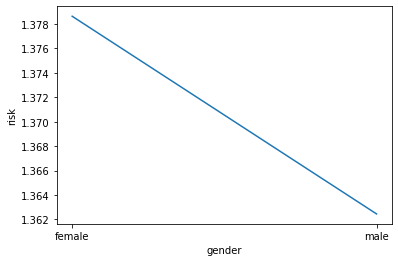

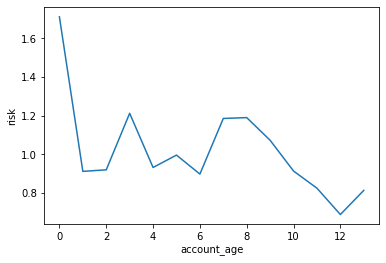

CPU times: user 1.73 s, sys: 213 ms, total: 1.94 s
Wall time: 37 s


In [ ]:
%%time
for col in categorical:
    df_group = X_train.groupby(by=col).is_churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    sns.lineplot(x=col, y="risk",
             data= df_group.compute())
    plt.show()

In [ ]:
%%time
for col in categorical:
    df_group = X_train.groupby(by=col).is_churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group.compute())

mean      diff      risk
city                              
1     0.063611 -0.030865  0.673306
3     0.134739  0.040263  1.426174
4     0.127638  0.033162  1.351008
5     0.131552  0.037076  1.392439
6     0.130343  0.035867  1.379640
7     0.109427  0.014951  1.158248
8     0.131784  0.037308  1.394894
9     0.129210  0.034734  1.367644
10    0.132528  0.038052  1.402765
11    0.120099  0.025623  1.271206
12    0.138781  0.044304  1.468947
13    0.123617  0.029141  1.308443
14    0.118847  0.024371  1.257955
15    0.127343  0.032867  1.347886
16    0.111709  0.017233  1.182407
17    0.104526  0.010049  1.106370
18    0.115497  0.021020  1.222495
19    0.123894  0.029418  1.311376
20    0.106542  0.012066  1.127714
21    0.152174  0.057698  1.610712
22    0.126789  0.032313  1.342024

mean      diff      risk
registered_via                              
3               0.171317  0.076841  1.813334
4               0.231429  0.136953  2.449605
7               0.044400 -0.050076  0.469961
9               0.127063  0.032587  1.344925
13              0.093925 -0.000551  0.994163

mean      diff      risk
gender                              
female  0.130249  0.035772  1.378639
male    0.128719  0.034243  1.362448

mean      diff      risk
account_age                              
0            0.161682  0.067206  1.711350
1            0.086175 -0.008301  0.912138
2            0.086919 -0.007557  0.920012
3            0.114550  0.020074  1.212473
4            0.088075 -0.006401  0.932245
5            0.094124 -0.000353  0.996269
6            0.084850 -0.009627  0.898106
7            0.112028  0.017552  1.185783
8            0.112443  0.017967  1.190178
9            0.101359  0.006883  1.072853
10           0.086335 -0.008141  0.913833
11           0.077951 -0.016525  0.825088
12           0.065092 -0.029384  0.688979
13           0.076888 -0.017589  0.813831

CPU times: user 1.4 s, sys: 162 ms, total: 1.56 s
Wall time: 36.4 s


By calculating the risk on the cities column we can see that city number 1 and city number 20  have risk values lower to 1, meaning that they have lower probability of churning. With regard of the registering methods, method number 7 have the lowest risk while method 4 have the highest risk. Also, we can see how accounts with less than one year old have the highest risk of churning followed by accounts with 3, 8 and 7 years old.

In [ ]:
df_group.tail()

mean      diff      risk
account_age                              
9            0.101359  0.006883  1.072853
10           0.086335 -0.008141  0.913833
11           0.077951 -0.016525  0.825088
12           0.065092 -0.029384  0.688979
13           0.076888 -0.017589  0.813831

In [ ]:
%%time
plt.figure(figsize=(50, 50))
sns.heatmap(X_train.corr().compute())

CPU times: user 7.05 s, sys: 1 s, total: 8.05 s
Wall time: 2min 46s


<AxesSubplot:>

In [ ]:
%%time
train_corr = pd.DataFrame(X_train.corr().compute())

CPU times: user 5.88 s, sys: 918 ms, total: 6.8 s
Wall time: 2min 45s


In [ ]:
%%time
train_corr.sort_values(by="is_churn")

CPU times: user 734 µs, sys: 98 µs, total: 832 µs
Wall time: 741 µs


is_churn      city        bd  registered_via  \
max_renew                  -0.402395 -0.102148 -0.066222        0.215856   
mean_pmethod_renew         -0.394173 -0.214014 -0.161584        0.213543   
max_pmethod_renew          -0.393428 -0.170389 -0.135637        0.193542   
min_pmethod_renew          -0.352527 -0.266454 -0.193899        0.204962   
max_transaction_year       -0.321817 -0.036858 -0.034635        0.015828   
min_payment_id             -0.260851 -0.331655 -0.288403        0.037230   
sum_pmethod_renew          -0.221650 -0.006759  0.042728        0.203837   
mean_payment_id            -0.219451 -0.325270 -0.309861        0.011776   
max_payment_id             -0.174336 -0.297443 -0.301040       -0.013243   
sum_payment_id             -0.170283  0.055627  0.082492        0.163542   
count_transaction_date     -0.166852  0.114947  0.141361        0.182614   
count_renew                -0.166852  0.114947  0.141361        0.182614   
count_auto_renew_&_cancel  -0.166852  0.114947  0.141361        0.182614   
count_is_cancel            -0.166852  0.114947  0.141361        0.182614   
registered_via             -0.080303  0.017883  0.067236        1.000000   
max_transaction_day        -0.062001  0.158718  0.145872        0.074510   
std_skip25_ratio           -0.030113 -0.155293 -0.128645        0.004158   
max_skip25_ratio           -0.022830  0.081285  0.069162        0.045097   
registration_init_month    -0.021653 -0.013539 -0.012203       -0.000004   
min_skip_ratio             -0.020459 -0.122479 -0.104614        0.010105   
min_skip25_ratio           -0.017816 -0.091847 -0.079234        0.009802   
mean_skip25_ratio          -0.016250 -0.152976 -0.145304       -0.022628   
sum_amount_paid            -0.015944  0.268431  0.272401        0.161512   
std_skip_ratio             -0.015841 -0.088402 -0.073369        0.008958   
std_num100_ratio           -0.015841 -0.088402 -0.073369        0.008958   
std_skip75_ratio           -0.014800 -0.061237 -0.051475        0.017274   
std_unq_ratio              -0.014542  0.018629  0.034951        0.037665   
max_skip_ratio             -0.014082  0.055772  0.040862        0.013123   
std_unpaid                 -0.013605  0.231967  0.246081        0.174449   
account_age                -0.012814  0.359377  0.399937        0.382322   
mean_skip_ratio            -0.012783 -0.151503 -0.147741       -0.021313   
std_skip50_ratio           -0.011729 -0.075147 -0.071231        0.006614   
std_skip985_ratio          -0.010146 -0.031688 -0.028300        0.019666   
min_skip50_ratio           -0.007346 -0.039316 -0.033315        0.005505   
sum_plan_days              -0.006528  0.134323  0.147794        0.152790   
max_skip75_ratio           -0.006504  0.139800  0.119333        0.059234   
sum_num100_ratio           -0.006253  0.296292  0.261812        0.108970   
max_skip50_ratio           -0.005691  0.143109  0.116400        0.053550   
registration_init_day      -0.005390 -0.005989 -0.003248        0.004107   
min_unq_secs_ratio         -0.005212 -0.059654 -0.050807       -0.023148   
count_date                 -0.005141  0.303679  0.260146        0.107864   
sum_price_list             -0.005093  0.235928  0.233537        0.131039   
min_total_secs             -0.005012 -0.060800 -0.051768       -0.023984   
min_daily_listening_ratio  -0.005012 -0.060800 -0.051768       -0.023984   
min_skip_secs_ratio        -0.004478 -0.049476 -0.040594       -0.019125   
mean_skip75_secs_ratio     -0.004393 -0.029820 -0.022517       -0.010700   
min_skip75_secs_ratio      -0.004166 -0.040670 -0.032836       -0.014247   
mean_skip985_secs_ratio    -0.004028 -0.030024 -0.021923       -0.008585   
min_skip75_ratio           -0.004013 -0.024120 -0.019848        0.004650   
min_skip25_secs_ratio      -0.003820 -0.045194 -0.037576       -0.018119   
mean_skip_secs_ratio       -0.003659 -0.031276 -0.023824       -0.011114   
sum_unq_ratio              -0.003530  0.299194  0.254762        0.103970   


In [ ]:
#selecting rows of feautures of interest
top_corr = train_corr[pow(train_corr['is_churn'],2)>pow(0.19,2)].copy()
top_corr.head()


is_churn      city        bd  registered_via  min_payment_id  \
is_churn         1.000000  0.082774  0.067796       -0.080303       -0.260851   
min_payment_id  -0.260851 -0.331655 -0.288403        0.037230        1.000000   
mean_payment_id -0.219451 -0.325270 -0.309861        0.011776        0.869521   
std_payment_id   0.235353  0.175672  0.113335       -0.077148       -0.711188   
min_plan_days    0.286867 -0.058278 -0.060573       -0.064417       -0.106951   

                 max_payment_id  mean_payment_id  std_payment_id  \
is_churn              -0.174336        -0.219451        0.235353   
min_payment_id         0.730371         0.869521       -0.711188   
mean_payment_id        0.939691         1.000000       -0.374914   
std_payment_id        -0.084167        -0.374914        1.000000   
min_plan_days         -0.135441        -0.143698        0.098919   

                 sum_payment_id  min_plan_days  max_plan_days  mean_plan_days  \
is_churn              -0.170283       0.286867       0.350187        0.384752   
min_payment_id         0.266696      -0.106951      -0.399786       -0.275227   
mean_payment_id        0.299896      -0.143698      -0.275605       -0.266925   
std_payment_id        -0.164199       0.098919       0.424750        0.307607   
min_plan_days         -0.371754       1.000000       0.488062        0.846846   

                 std_plan_days  sum_plan_days  min_price_list  max_price_list  \
is_churn              0.248902      -0.006528        0.278579        0.348231   
min_payment_id       -0.393023       0.049201       -0.121070       -0.425766   
mean_payment_id      -0.271560       0.120810       -0.159194       -0.305478   
std_payment_id        0.419760       0.034049        0.095745        0.434631   
min_plan_days         0.004233      -0.141600        0.960775        0.464334   

                 mean_price_list  std_price_list  sum_price_list  \
is_churn                0.384833        0.259582       -0.005093   
min_payment_id         -0.322484       -0.416058       -0.039368   
mean_payment_id        -0.314266       -0.304913        0.019248   
std_payment_id          0.330704        0.428345        0.060589   
min_plan_days           0.800101        0.038035       -0.198120   

                 min_amount_paid  max_amount_paid  mean_amount_paid  \
is_churn                0.263473         0.345199          0.380981   
min_payment_id         -0.157633        -0.428348         -0.340053   
mean_payment_id        -0.231063        -0.305752         -0.337808   
std_payment_id          0.056591         0.436267          0.329472   
min_plan_days           0.825147         0.457369          0.782810   

                 std_amount_paid  sum_amount_paid  max_renew  count_renew  \
is_churn                0.270699        -0.015944  -0.402395    -0.166852   
min_payment_id         -0.382307        -0.083537   0.353061     0.152909   
mean_payment_id        -0.248524        -0.045838   0.345668     0.166135   
std_payment_id          0.442777         0.051921  -0.249457    -0.130016   
min_plan_days           0.112884        -0.232982  -0.292315    -0.391945   

                 count_transaction_date  max_is_cancel  count_is_cancel  \
is_churn                      -0.166852       0.105993        -0.166852   
min_payment_id                 0.152909       0.008147         0.152909   
mean_payment_id                0.166135       0.107615         0.166135   
std_payment_id                -0.130016       0.120453        -0.130016   
min_plan_days                 -0.391945      -0.138042        -0.391945   

                 max_auto_renew_&_cancel  count_auto_renew_&_cancel  \
is_churn                        0.105993                  -0.166852   
min_payment_id                  0.008147                   0.152909   
mean_payment_id                 0.107615                   0.166135   
std_payment_id                  0.120453                  -0.130016   
min_plan_days                  -0.138042  

In [ ]:
%%time
#dropping columns of non-relevant feautures
for x in enumerate(top_corr.columns):
    if x[1] not in list(top_corr.index):
        top_corr.drop(columns=x[1], inplace=True)

CPU times: user 41.8 ms, sys: 3.88 ms, total: 45.7 ms
Wall time: 43.6 ms


In [ ]:
top_corr.head()

is_churn  min_payment_id  mean_payment_id  std_payment_id  \
is_churn         1.000000       -0.260851        -0.219451        0.235353   
min_payment_id  -0.260851        1.000000         0.869521       -0.711188   
mean_payment_id -0.219451        0.869521         1.000000       -0.374914   
std_payment_id   0.235353       -0.711188        -0.374914        1.000000   
min_plan_days    0.286867       -0.106951        -0.143698        0.098919   

                 min_plan_days  max_plan_days  mean_plan_days  std_plan_days  \
is_churn              0.286867       0.350187        0.384752       0.248902   
min_payment_id       -0.106951      -0.399786       -0.275227      -0.393023   
mean_payment_id      -0.143698      -0.275605       -0.266925      -0.271560   
std_payment_id        0.098919       0.424750        0.307607       0.419760   
min_plan_days         1.000000       0.488062        0.846846       0.004233   

                 min_price_list  max_price_list  mean_price_list  \
is_churn               0.278579        0.348231         0.384833   
min_payment_id        -0.121070       -0.425766        -0.322484   
mean_payment_id       -0.159194       -0.305478        -0.314266   
std_payment_id         0.095745        0.434631         0.330704   
min_plan_days          0.960775        0.464334         0.800101   

                 std_price_list  min_amount_paid  max_amount_paid  \
is_churn               0.259582         0.263473         0.345199   
min_payment_id        -0.416058        -0.157633        -0.428348   
mean_payment_id       -0.304913        -0.231063        -0.305752   
std_payment_id         0.428345         0.056591         0.436267   
min_plan_days          0.038035         0.825147         0.457369   

                 mean_amount_paid  std_amount_paid  max_renew  \
is_churn                 0.380981         0.270699  -0.402395   
min_payment_id          -0.340053        -0.382307   0.353061   
mean_payment_id         -0.337808        -0.248524   0.345668   
std_payment_id           0.329472         0.442777  -0.249457   
min_plan_days            0.782810         0.112884  -0.292315   

                 min_days_to_expire  max_days_to_expire  min_pmethod_renew  \
is_churn                   0.219065            0.264476          -0.352527   
min_payment_id            -0.154390           -0.233478           0.647481   
mean_payment_id           -0.185949           -0.113548           0.530617   
std_payment_id             0.105285            0.271984          -0.500296   
min_plan_days              0.297096            0.034148          -0.168630   

                 max_pmethod_renew  mean_pmethod_renew  sum_pmethod_renew  \
is_churn                 -0.393428           -0.394173          -0.221650   
min_payment_id            0.492686            0.574941           0.347050   
mean_payment_id           0.526235            0.571047           0.347492   
std_payment_id           -0.264146           -0.371955          -0.229670   
min_plan_days            -0.264373           -0.244500          -0.331067   

                 max_transaction_year  
is_churn                    -0.321817  
min_payment_id               0.129099  
mean_payment_id              0.113514  
std_payment_id              -0.120847  
min_plan_days               -0.337588

Text(0.5, 1.0, 'Feauture Importance')

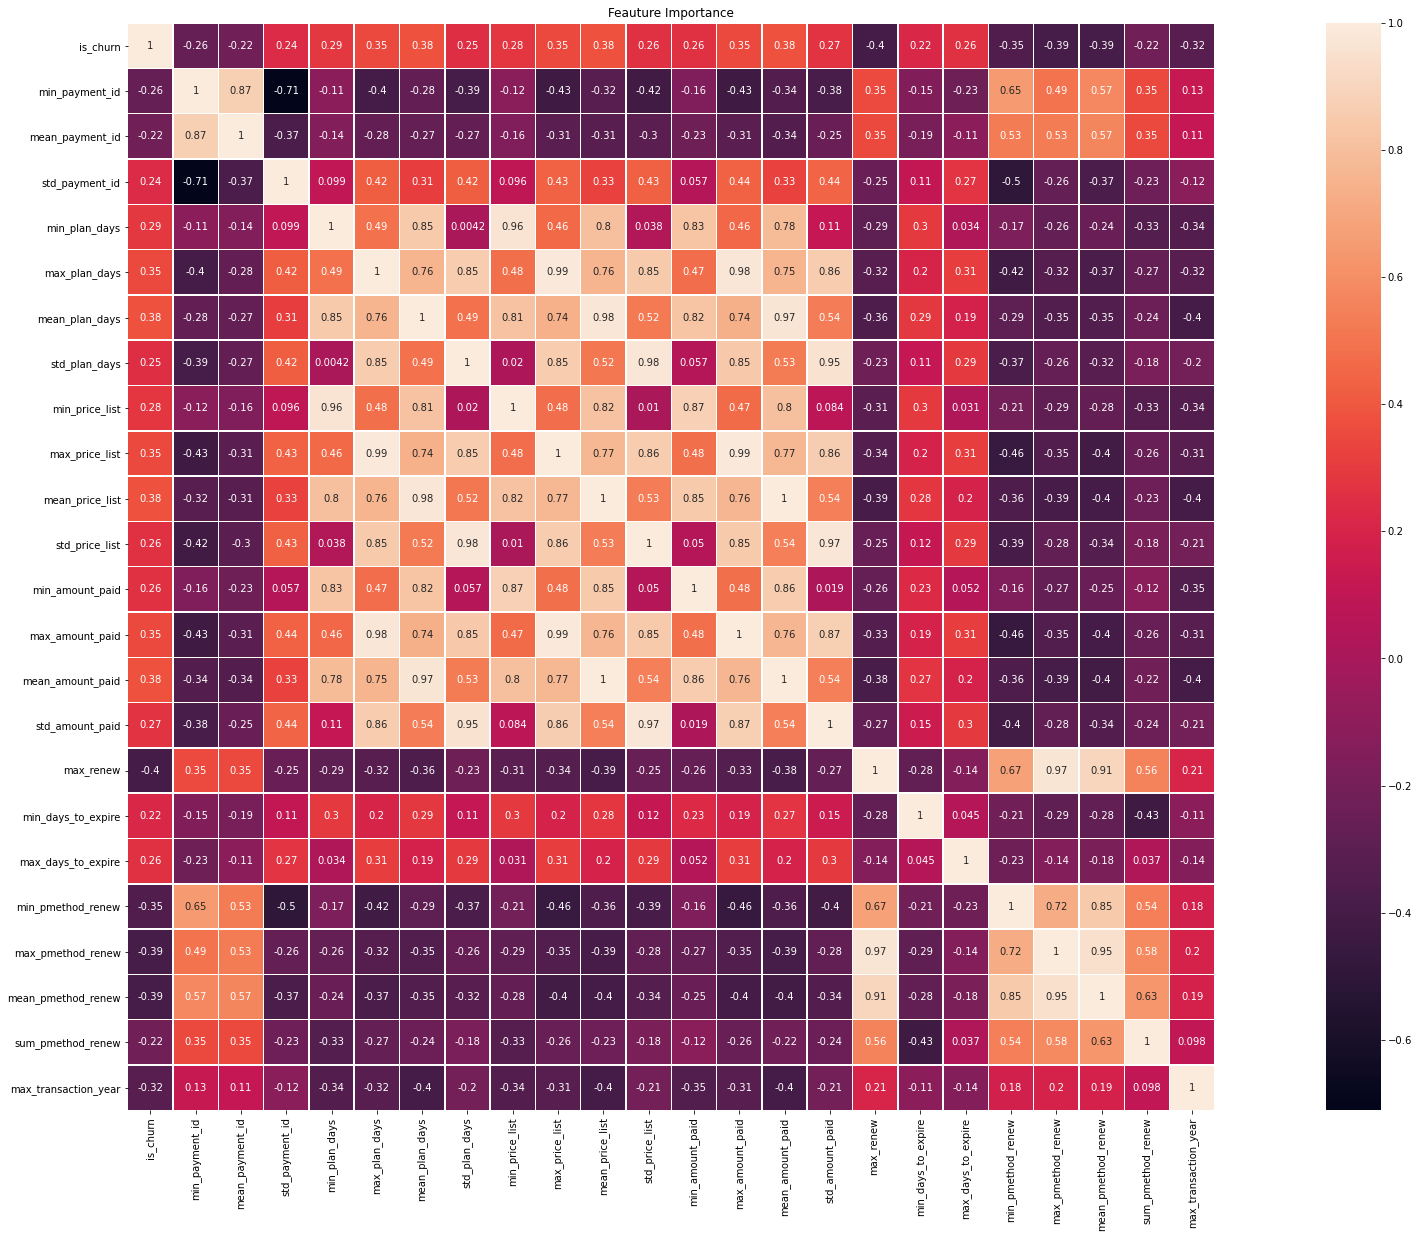

In [ ]:
x=list(top_corr.columns)
y=list(top_corr.index)
plt.figure(figsize=(40,20))
sns.heatmap(top_corr,
           square=True,
           annot=True,
           linewidths=0.5,
           xticklabels=x,
           yticklabels=y)
plt.title("Feauture Importance")

The most positive correlated feautures are mean_price_list, mean_plan_days, mean_amount_paid, max_plan_days and max_price_list. Furthermore the mos negative correlated feautures are, max_renew, mean_pmethod_renew (paymemth method that also had auto renew), min_pmethod_renew.

## Data preparation

In [ ]:
X_train.dtypes

msno                                  object
is_churn                               int64
city                                   int64
bd                                     int64
gender                                object
registered_via                         int64
registration_init_time        datetime64[ns]
min_payment_id                         int64
max_payment_id                         int64
mean_payment_id                      float64
std_payment_id                       float64
sum_payment_id                         int64
min_plan_days                          int64
max_plan_days                          int64
mean_plan_days                       float64
std_plan_days                        float64
sum_plan_days                          int64
min_price_list                         int64
max_price_list                         int64
mean_price_list                      float64
std_price_list                       float64
sum_price_list                         int64
min_amount

In [ ]:
%%time
X_test = dd.read_parquet('X_test.parquet.gzip', engine = 'pyarrow')

CPU times: user 4.7 ms, sys: 224 µs, total: 4.93 ms
Wall time: 4.61 ms


In [ ]:
%%time
X_test.head()

CPU times: user 14.7 ms, sys: 745 µs, total: 15.5 ms
Wall time: 140 ms


msno
769495  3UaP2pR+6UNC5itbJoIvXpH35HUazuFluwnAhddOtmo=
422280  FeEB8Wue3p1b9VVQKJNeL7PEFT55to/UD3scdfXTj1Y=
302183  vhAFRpENdrS1pOZ5Cg9Vobsd2w21Oz5gH3RNUHbQqgY=
116884  J8W6YYqqfhQ5hDTO9u92TwXeSbTS1yyMRM03sq449oE=
328078  9cvLjtzf29AF3vAUSi4hDTPNfXOYYhFxnK/LfSnFaME=

In [ ]:
%%time
X_test = X_test.merge(dd.read_parquet('y_test.parquet.gzip', engine='pyarrow'),left_index=True, right_index=True)
X_test.head()

CPU times: user 34.2 ms, sys: 1.35 ms, total: 35.6 ms
Wall time: 174 ms


msno  is_churn
769495  3UaP2pR+6UNC5itbJoIvXpH35HUazuFluwnAhddOtmo=         0
422280  FeEB8Wue3p1b9VVQKJNeL7PEFT55to/UD3scdfXTj1Y=         0
302183  vhAFRpENdrS1pOZ5Cg9Vobsd2w21Oz5gH3RNUHbQqgY=         0
116884  J8W6YYqqfhQ5hDTO9u92TwXeSbTS1yyMRM03sq449oE=         0
328078  9cvLjtzf29AF3vAUSi4hDTPNfXOYYhFxnK/LfSnFaME=         0

In [ ]:
%%time
X_test =X_test.merge(dd.read_parquet('test_members_logs_trans.parquet.gzip', engine='pyarrow'), on='msno')
X_test

CPU times: user 45.7 ms, sys: 3.9 ms, total: 49.6 ms
Wall time: 48 ms


Dask DataFrame Structure:
                 msno is_churn   city     bd  gender registered_via registration_init_time min_payment_id max_payment_id mean_payment_id std_payment_id sum_payment_id min_plan_days max_plan_days mean_plan_days std_plan_days sum_plan_days min_price_list max_price_list mean_price_list std_price_list sum_price_list min_amount_paid max_amount_paid mean_amount_paid std_amount_paid sum_amount_paid max_renew count_renew min_transaction_date max_transaction_date count_transaction_date min_expire_date max_expire_date max_is_cancel count_is_cancel max_auto_renew_&_cancel count_auto_renew_&_cancel min_days_to_expire max_days_to_expire mean_days_to_expire std_days_to_expire sum_days_to_expire min_unpaid max_unpaid mean_unpaid std_unpaid sum_unpaid min_pmethod_renew max_pmethod_renew mean_pmethod_renew std_pmethod_renew sum_pmethod_renew        min_date        max_date count_date min_num_25 max_num_25 mean_num_25 std_num_25 sum_num_25 min_num_50 max_num_50 mean_num_50 std_num_50 sum_num_50 min_num_75 max_num_75 mean_num_75 std_num_75 sum_num_75 min_num_985 max_num_985 mean_num_985 std_num_985 sum_num_985 min_num_100 max_num_100 mean_num_100 std_num_100 sum_num_100 min_num_unq max_num_unq mean_num_unq std_num_unq sum_num_unq min_total_secs max_total_secs mean_total_secs std_total_secs sum_total_secs min_skip_ratio max_skip_ratio mean_skip_ratio std_skip_ratio sum_skip_ratio min_skip25_ratio max_skip25_ratio mean_skip25_ratio std_skip25_ratio sum_skip25_ratio min_skip50_ratio max_skip50_ratio mean_skip50_ratio std_skip50_ratio sum_skip50_ratio min_skip75_ratio max_skip75_ratio mean_skip75_ratio std_skip75_ratio sum_skip75_ratio min_skip985_ratio max_skip985_ratio mean_skip985_ratio std_skip985_ratio sum_skip985_ratio min_num100_ratio max_num100_ratio mean_num100_ratio std_num100_ratio sum_num100_ratio min_unq_ratio max_unq_ratio mean_unq_ratio std_unq_ratio sum_unq_ratio min_unq_secs_ratio max_unq_secs_ratio mean_unq_secs_ratio std_unq_secs_ratio sum_unq_secs_ratio min_num100_secs_ratio max_num100_secs_ratio mean_num100_secs_ratio std_num100_secs_ratio sum_num100_secs_ratio min_skip_secs_ratio max_skip_secs_ratio mean_skip_secs_ratio std_skip_secs_ratio sum_skip_secs_ratio min_skip25_secs_ratio max_skip25_secs_ratio mean_skip25_secs_ratio std_skip25_secs_ratio sum_skip25_secs_ratio min_skip50_secs_ratio max_skip50_secs_ratio mean_skip50_secs_ratio std_skip50_secs_ratio sum_skip50_secs_ratio min_skip75_secs_ratio max_skip75_secs_ratio mean_skip75_secs_ratio std_skip75_secs_ratio sum_skip75_secs_ratio min_skip985_secs_ratio max_skip985_secs_ratio mean_skip985_secs_ratio std_skip985_secs_ratio sum_skip985_secs_ratio min_daily_listening_ratio max_daily_listening_ratio mean_daily_listening_ratio std_daily_listening_ratio sum_daily_listening_ratio registration_init_year registration_init_month registration_init_day max_transaction_year max_transaction_month max_transaction_day account_age
npartitions=2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
%%time
X_test.head()

CPU times: user 86.1 ms, sys: 15.4 ms, total: 102 ms
Wall time: 1.82 s


msno  is_churn  city  bd  gender  \
0  FeEB8Wue3p1b9VVQKJNeL7PEFT55to/UD3scdfXTj1Y=         0     1   0    None   
1  J8W6YYqqfhQ5hDTO9u92TwXeSbTS1yyMRM03sq449oE=         0     4  30  female   
2  8rn2htAhBPxQ2rU0n1vaBgrudA/Z22wfX1DOF6v7xdE=         1     1   0    None   
3  ydif5GIy3fXg2PrjCeBAU/vAiHXMC+fdsNW5zeAzaWc=         0     1   0    None   
4  G0fzrMg+1zlMal1QJZFgKmGUQVMqVRPDYsczMwu1aMw=         0     1   0    None   

   registered_via registration_init_time  min_payment_id  max_payment_id  \
0               7             2016-10-28              41              41   
1               9             2016-02-29              40              40   
2               4             2016-06-05              20              38   
3               7             2015-12-23              41              41   
4               7             2014-04-03              41              41   

   mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
0             41.0        0.000000             246             30   
1             40.0        0.000000             360             30   
2             26.0       10.392305              78             30   
3             41.0        0.000000             656             30   
4             41.0        0.000000            1107              0   

   max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
0             30       30.000000       0.000000            180   
1             30       30.000000       0.000000            270   
2            100       76.666667      40.414519            230   
3             30       30.000000       0.000000            480   
4             30       28.888889       5.773503            780   

   min_price_list  max_price_list  mean_price_list  std_price_list  \
0              99              99        99.000000        0.000000   
1             149             149       149.000000        0.000000   
2             149             480       369.666667      191.102939   
3              99              99        99.000000        0.000000   
4               0             149       143.481481       28.675063   

   sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
0             594               99               99         99.000000   
1            1341              149              149        149.000000   
2            1109              149              480        369.666667   
3            1584               99               99         99.000000   
4            3874              149              149        149.000000   

   std_amount_paid  sum_amount_paid  max_renew  count_renew  \
0         0.000000              594          1            6   
1         0.000000             1341          1            9   
2       191.102939             1109          0            3   
3         0.000000             1584          1           16   
4         0.000000             4023          1           27   

  min_transaction_date max_transaction_date  count_transaction_date  \
0           2016-10-28           2017-03-27                       6   
1           2016-02-29           2017-03-08                       9   
2           2016-06-09           2017-02-22                       3   
3           2015-12-23           2017-03-22                      16   
4           2015-01-02           2017-03-02                      27   

  min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
0      2016-11-27      2017-04-27              0                6   
1      2016-03-31      2017-04-07              1                9   
2      2016-09-17      2017-03-24              0                3   
3      2016-01-22      2017-04-22              0               16   
4      2015-02-02      2017-04-02              0               27   

   max_auto_renew_&_cancel  count_auto_renew_&_cancel  min_days_to_expire  \
0                        0                          6                -335   
1                        1                          9           

In [ ]:
X_test['gender'] = X_test['gender'].astype('category') 
X_test['gender'] = X_test['gender'].cat.add_categories('not_specified')
X_test['gender'] = X_test['gender'].fillna('not_specified')
X_test['gender'].head()


0    not_specified
1           female
2    not_specified
3    not_specified
4    not_specified
Name: gender, dtype: category
Categories (3, object): ['female', 'male', 'not_specified']

In [ ]:
%%time

X_train = dd.read_parquet('X_train.parquet.gzip', engine = 'pyarrow')

X_train = X_train.merge(dd.read_parquet('y_train.parquet.gzip', engine='pyarrow'),left_index=True, right_index=True)

X_train =X_train.merge(dd.read_parquet('train_members_logs_trans.parquet.gzip', engine='pyarrow'), on='msno')

#read from parquet in case kernel needs to restart.
X_train['gender'] = X_train['gender'].astype('category')
X_train['gender'] = X_train['gender'].cat.add_categories('not_specified')
X_train['gender'] = X_train['gender'].fillna('not_specified')
display(X_train['gender'].head())


0           female
1    not_specified
2           female
3             male
4             male
Name: gender, dtype: category
Categories (3, object): ['female', 'male', 'not_specified']

CPU times: user 327 ms, sys: 68.1 ms, total: 395 ms
Wall time: 7.57 s


In [ ]:
%%time
from dask_ml.preprocessing import DummyEncoder
#from dask_ml.compose import ColumnTransformer
de = DummyEncoder()

X = X_train.drop(columns=["msno", "is_churn", "registration_init_time", "min_date", "max_date", "min_transaction_date", "max_transaction_date", "min_expire_date", "max_expire_date"])
Y =  X_train["is_churn"]

X_eval =  X_test.drop(columns=["msno", "is_churn", "registration_init_time", "min_date", "max_date", "min_transaction_date", "max_transaction_date", "min_expire_date", "max_expire_date"])
y_eval = X_test['is_churn']

# determine categorical and numerical features
#categorical_ix = X.select_dtypes(include=['category']).columns
#categories = [X[column].unique() for column in X[categorical_ix]]
#
# define the data preparation for the columns
#t = [( 'cat' , OneHotEncoder(categories=categories,  sparse=False), categorical_ix)]
#col_transform = ColumnTransformer(transformers=t, remainder='passthrough') 
X = X.categorize()
data = de.fit_transform(X)

labels = Y
X_eval = X_eval.categorize()
X_eval = de.transform(X_eval)


CPU times: user 578 ms, sys: 75 ms, total: 653 ms
Wall time: 12.1 s


In [ ]:
data.head()

city  bd  registered_via  min_payment_id  max_payment_id  mean_payment_id  \
0    15  25               9              39              39        39.000000   
1     1   0               7              41              41        41.000000   
2    10  43               9              31              31        31.000000   
3    10  28               9              26              39        38.409091   
4    22  28               9              37              37        37.000000   

   std_payment_id  sum_payment_id  min_plan_days  max_plan_days  \
0        0.000000             819              0             31   
1        0.000000             492             30             30   
2        0.000000             713              0             30   
3        2.771609             845              0             31   
4        0.000000             999              0             31   

   mean_plan_days  std_plan_days  sum_plan_days  min_price_list  \
0       28.714286       6.588952            603               0   
1       30.000000       0.000000            360              99   
2       22.173913      13.469333            510               0   
3       27.409091       8.878326            603               0   
4       29.037037       5.814316            784               0   

   max_price_list  mean_price_list  std_price_list  sum_price_list  \
0             149       141.904762       32.514466            2980   
1              99        99.000000        0.000000            1188   
2             149       110.130435       66.897686            2533   
3             149       135.454545       43.842497            2980   
4             149       143.481481       28.675063            3874   

   min_amount_paid  max_amount_paid  mean_amount_paid  std_amount_paid  \
0              149              149        149.000000         0.000000   
1               99               99         99.000000         0.000000   
2              149              149        149.000000         0.000000   
3                0              149        142.227273        31.766907   
4              149              149        149.000000         0.000000   

   sum_amount_paid  max_renew  count_renew  count_transaction_date  \
0             3129          1           21                      21   
1             1188          1           12                      12   
2             3427          1           23                      23   
3             3129          1           22                      22   
4             4023          1           27                      27   

   max_is_cancel  count_is_cancel  max_auto_renew_&_cancel  \
0              0               21                        0   
1              0               12                        0   
2              0               23                        0   
3              0               22                        0   
4              0               27                        0   

   count_auto_renew_&_cancel  min_days_to_expire  max_days_to_expire  \
0                         21                -314                  53   
1                         12                -335                  31   
2                         23                -335                  31   
3                         22                -301                  67   
4                         27                -335                  32   

   mean_days_to_expire  std_days_to_expire  sum_days_to_expire  min_unpaid  \
0            -0.142857          131.021100                  -3        -149   
1            -0.083333          105.475080                  -1           0   
2            -1.347826          105.126594                 -31        -149   
3           -22.727273          154.227470                -500        -149   
4             3.444444           97.410051                  93        -149   

   max_unpaid  mean_unpaid  std_unpaid  sum_unpaid  min_pmethod_renew  \
0           0    -7.095238   32.514466        -149                 39   
1       

In [ ]:
X_eval.head()

city  bd  registered_via  min_payment_id  max_payment_id  mean_payment_id  \
0     1   0               7              41              41             41.0   
1     4  30               9              40              40             40.0   
2     1   0               4              20              38             26.0   
3     1   0               7              41              41             41.0   
4     1   0               7              41              41             41.0   

   std_payment_id  sum_payment_id  min_plan_days  max_plan_days  \
0        0.000000             246             30             30   
1        0.000000             360             30             30   
2       10.392305              78             30            100   
3        0.000000             656             30             30   
4        0.000000            1107              0             30   

   mean_plan_days  std_plan_days  sum_plan_days  min_price_list  \
0       30.000000       0.000000            180              99   
1       30.000000       0.000000            270             149   
2       76.666667      40.414519            230             149   
3       30.000000       0.000000            480              99   
4       28.888889       5.773503            780               0   

   max_price_list  mean_price_list  std_price_list  sum_price_list  \
0              99        99.000000        0.000000             594   
1             149       149.000000        0.000000            1341   
2             480       369.666667      191.102939            1109   
3              99        99.000000        0.000000            1584   
4             149       143.481481       28.675063            3874   

   min_amount_paid  max_amount_paid  mean_amount_paid  std_amount_paid  \
0               99               99         99.000000         0.000000   
1              149              149        149.000000         0.000000   
2              149              480        369.666667       191.102939   
3               99               99         99.000000         0.000000   
4              149              149        149.000000         0.000000   

   sum_amount_paid  max_renew  count_renew  count_transaction_date  \
0              594          1            6                       6   
1             1341          1            9                       9   
2             1109          0            3                       3   
3             1584          1           16                      16   
4             4023          1           27                      27   

   max_is_cancel  count_is_cancel  max_auto_renew_&_cancel  \
0              0                6                        0   
1              1                9                        1   
2              0                3                        0   
3              0               16                        0   
4              0               27                        0   

   count_auto_renew_&_cancel  min_days_to_expire  max_days_to_expire  \
0                          6                -335                  31   
1                          9                   4                  36   
2                          3                -266                 100   
3                         16                -335                  31   
4                         27                -335                  31   

   mean_days_to_expire  std_days_to_expire  sum_days_to_expire  min_unpaid  \
0           -30.833333          149.014653                -185           0   
1            28.666667            9.797959                 258           0   
2           -45.333333          194.281583                -136           0   
3           -15.312500          124.796217                -245           0   
4             3.333333           97.377931                  90        -149   

   max_unpaid  mean_unpaid  std_unpaid  sum_unpaid  min_pmethod_renew  \
0           0     0.000000    0.000000           0                 41   
1       

In [ ]:
pdtrain = xgb.DMatrix(data.compute(), label=labels.compute(), feature_names=data.columns)
dval = xgb.DMatrix(X_eval.compute(), label=y_eval.compute(), feature_names=X_eval.columns)

In [ ]:
%%time
from sklearn.model_selection import ParameterGrid
xgb_params = ParameterGrid({
    'eta':[ 0.3, 0.05],
    'max_depth':[6, 12, 24],
    'min_child_weight': [1, 15, 30],
    'objective': ['binary:logistic'],
    'gpu_id':[1],
    'tree_method':['gpu_hist']
})


CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 26.7 µs


In [ ]:
%%time
results = []

for i, params in enumerate(xgb_params):
    cv_result = xgb.cv(params, 
                       pdtrain, 
                       num_boost_round=3000, 
                       nfold=5, 
                       stratified=True, 
                       folds=None,
                       metrics=("logloss"),
                       early_stopping_rounds=10, 
                       callbacks=None, 
                       shuffle=True,
                       verbose_eval=None, 
                       as_pandas=True)

    print(cv_result)

    params["n_estimators"] = len(cv_result) - 1

    results.append({"test-logloss-mean": cv_result['test-logloss-mean'].values[-1], "params": params})

 

   
results = sorted(results, key=lambda k: k['test-logloss-mean'])
best_params = results[0]["params"]

     train-logloss-mean  train-logloss-std  test-logloss-mean  \
0              0.476261           0.000647           0.476447   
1              0.356349           0.000272           0.356563   
2              0.280600           0.000233           0.280917   
3              0.231851           0.000343           0.232243   
4              0.196369           0.000404           0.196888   
5              0.171749           0.000494           0.172378   
6              0.154396           0.000373           0.155107   
7              0.141381           0.000811           0.142231   
8              0.131439           0.001102           0.132450   
9              0.122813           0.000183           0.123789   
10             0.117301           0.000197           0.118413   
11             0.113070           0.000223           0.114327   
12             0.109647           0.000165           0.111056   
13             0.106727           0.000150           0.108209   
14             0.104446  

In [ ]:
%%time
final_model = xgb.train(best_params, dtrain=pdtrain, num_boost_round=best_params['n_estimators'], verbose_eval=True)


[00:51:18] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:51:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 52.2 s, sys: 511 ms, total: 52.7 s
Wall time: 52.2 s


In [ ]:
%%time
probs = final_model.predict(dval)

y_test_fr = pd.DataFrame(y_eval)

y_test_fr['PROBABILITY'] = probs

y_test_fr.head()

CPU times: user 2.8 s, sys: 108 ms, total: 2.91 s
Wall time: 8.01 s


0  PROBABILITY
0  0     0.000198
1  0     0.111723
2  1     0.921623
3  0     0.000191
4  0     0.000297

In [ ]:
y_test_fr = y_test_fr.rename(columns={0:'is_churn'})
y_test_fr.head()

is_churn  PROBABILITY
0         0     0.000198
1         0     0.111723
2         1     0.921623
3         0     0.000191
4         0     0.000297

In [ ]:
y_test_fr.tail()

is_churn  PROBABILITY
170842         0     0.000651
170843         0     0.067238
170844         0     0.000200
170845         0     0.000178
170846         0     0.000232

In [ ]:
X_test =  X_test.compute().reset_index(drop=True)

In [ ]:
y_test_fr = y_test_fr.merge(X_test, left_index=True, right_index=True)
y_test_fr.head()

is_churn_x  PROBABILITY                                          msno  \
0           0     0.000198  FeEB8Wue3p1b9VVQKJNeL7PEFT55to/UD3scdfXTj1Y=   
1           0     0.111723  J8W6YYqqfhQ5hDTO9u92TwXeSbTS1yyMRM03sq449oE=   
2           1     0.921623  8rn2htAhBPxQ2rU0n1vaBgrudA/Z22wfX1DOF6v7xdE=   
3           0     0.000191  ydif5GIy3fXg2PrjCeBAU/vAiHXMC+fdsNW5zeAzaWc=   
4           0     0.000297  G0fzrMg+1zlMal1QJZFgKmGUQVMqVRPDYsczMwu1aMw=   

   is_churn_y  city  bd         gender  registered_via registration_init_time  \
0           0     1   0  not_specified               7             2016-10-28   
1           0     4  30         female               9             2016-02-29   
2           1     1   0  not_specified               4             2016-06-05   
3           0     1   0  not_specified               7             2015-12-23   
4           0     1   0  not_specified               7             2014-04-03   

   min_payment_id  max_payment_id  mean_payment_id  std_payment_id  \
0              41              41             41.0        0.000000   
1              40              40             40.0        0.000000   
2              20              38             26.0       10.392305   
3              41              41             41.0        0.000000   
4              41              41             41.0        0.000000   

   sum_payment_id  min_plan_days  max_plan_days  mean_plan_days  \
0             246             30             30       30.000000   
1             360             30             30       30.000000   
2              78             30            100       76.666667   
3             656             30             30       30.000000   
4            1107              0             30       28.888889   

   std_plan_days  sum_plan_days  min_price_list  max_price_list  \
0       0.000000            180              99              99   
1       0.000000            270             149             149   
2      40.414519            230             149             480   
3       0.000000            480              99              99   
4       5.773503            780               0             149   

   mean_price_list  std_price_list  sum_price_list  min_amount_paid  \
0        99.000000        0.000000             594               99   
1       149.000000        0.000000            1341              149   
2       369.666667      191.102939            1109              149   
3        99.000000        0.000000            1584               99   
4       143.481481       28.675063            3874              149   

   max_amount_paid  mean_amount_paid  std_amount_paid  sum_amount_paid  \
0               99         99.000000         0.000000              594   
1              149        149.000000         0.000000             1341   
2              480        369.666667       191.102939             1109   
3               99         99.000000         0.000000             1584   
4              149        149.000000         0.000000             4023   

   max_renew  count_renew min_transaction_date max_transaction_date  \
0          1            6           2016-10-28           2017-03-27   
1          1            9           2016-02-29           2017-03-08   
2          0            3           2016-06-09           2017-02-22   
3          1           16           2015-12-23           2017-03-22   
4          1           27           2015-01-02           2017-03-02   

   count_transaction_date min_expire_date max_expire_date  max_is_cancel  \
0                       6      2016-11-27      2017-04-27              0   
1                       9      2016-03-31      2017-04-07              1   
2                       3      2016-09-17      2017-03-24              0   
3                      16      2016-01-22      2017-04-22              0   
4                      27      2015-02-02      2017-04-02              0   

   count_is_cancel  max_auto_renew_&_cancel  count_auto_renew_&_cancel  \
0 

In [ ]:
%%time
bins = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
names = [ '<0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

y_test_fr['churn_proba_range'] = pd.cut(y_test_fr['PROBABILITY'], bins, labels=names)

display(y_test_fr.dtypes)

is_churn_x                             int64
PROBABILITY                          float32
msno                                  object
is_churn_y                             int64
city                                   int64
bd                                     int64
gender                              category
registered_via                         int64
registration_init_time        datetime64[ns]
min_payment_id                         int64
max_payment_id                         int64
mean_payment_id                      float64
std_payment_id                       float64
sum_payment_id                         int64
min_plan_days                          int64
max_plan_days                          int64
mean_plan_days                       float64
std_plan_days                        float64
sum_plan_days                          int64
min_price_list                         int64
max_price_list                         int64
mean_price_list                      float64
std_price_

CPU times: user 7.91 ms, sys: 1.87 ms, total: 9.78 ms
Wall time: 7.87 ms


In [ ]:
y_test_fr.tail()

is_churn_x  PROBABILITY                                          msno  \
170842           0     0.000651  PWRBAeMdKIPvdY34/+esgaN9jZ9B/9prF0oMoHYusvo=   
170843           0     0.067238  hKMwt+ZOZyDg0v/IDE95KpGZY7H+WidNrzR/ls5F0r0=   
170844           0     0.000200  lIyp8aXiKAZ37SF2dlCzKi/aCIEqF7Rx3dbzLcOzoCU=   
170845           0     0.000178  dhQDLl3A/E/BJ3SAsKGf1wat7RNrA9plPY1tuI0HwXc=   
170846           0     0.000232  xMDBwLWnKlnPYifDE63t51ecAuGFJnOEucSEKmUPaVM=   

        is_churn_y  city  bd         gender  registered_via  \
170842           0    22  28           male               9   
170843           0     4  43           male               7   
170844           0     1   0  not_specified               7   
170845           0    22  28         female               9   
170846           0     6  26         female               9   

       registration_init_time  min_payment_id  max_payment_id  \
170842             2013-12-09              40              40   
170843             2011-06-20              35              41   
170844             2016-12-26              41              41   
170845             2005-03-11              34              34   
170846             2013-12-31              39              39   

        mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
170842             40.0        0.000000            1080              0   
170843             37.9        2.685351             379              7   
170844             41.0        0.000000             164             30   
170845             34.0        0.000000             782              0   
170846             39.0        0.000000             819              0   

        max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
170842             31       29.037037       5.814316            784   
170843             30       27.700000       7.273239            277   
170844             30       30.000000       0.000000            120   
170845             30       22.173913      13.469333            510   
170846             31       28.714286       6.588952            603   

        min_price_list  max_price_list  mean_price_list  std_price_list  \
170842               0             149       143.481481       28.675063   
170843               0             180       149.600000       54.774690   
170844              99              99        99.000000        0.000000   
170845               0             149       110.130435       66.897686   
170846               0             149       141.904762       32.514466   

        sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
170842            3874              149              149             149.0   
170843            1496                0              180             149.6   
170844             396               99               99              99.0   
170845            2533              149              149             149.0   
170846            2980              149              149             149.0   

        std_amount_paid  sum_amount_paid  max_renew  count_renew  \
170842          0.00000             4023          1           27   
170843         54.77469             1496          1           10   
170844          0.00000              396          1            4   
170845          0.00000             3427          1           23   
170846          0.00000             3129          1           21   

       min_transaction_date max_transaction_date  count_transaction_date  \
170842           2015-01-10           2017-03-10                      27   
170843           2015-01-08           2017-03-23                      10   
170844           2016-12-26           2017-03-26                       4   
170845           2015-03-31           2017-03-31                      23   
170846           2015-01-31           2017-03-31                      21   

       min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
170842      2015-02

In [ ]:
%%time
y_test_fr.to_parquet('test_proba.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 10.7 s, sys: 302 ms, total: 11 s
Wall time: 10.6 s


In [ ]:
y_test_fr = pd.read_parquet('test_proba.parquet.gzip', engine='pyarrow')

In [ ]:
churn_lift = pd.DataFrame(y_test_fr.groupby(
     'churn_proba_range').agg(
                            churn_proba_range_count = ('churn_proba_range', 'count'),
                             range_churn_rate = ('is_churn_x', 'mean')
 )
                          )
churn_lift = churn_lift.reset_index()
churn_lift.head(10)

churn_proba_range  churn_proba_range_count  range_churn_rate
0              <0.1                   146356          0.008192
1           0.1-0.2                     5576          0.142575
2           0.2-0.3                     2114          0.255440
3           0.3-0.4                     1355          0.365314
4           0.4-0.5                     1098          0.496357
5           0.5-0.6                     1007          0.575968
6           0.6-0.7                     1056          0.680871
7           0.7-0.8                     1335          0.761049
8           0.8-0.9                     2051          0.855680
9           0.9-1.0                     8899          0.968985

<AxesSubplot:title={'center':'Churn Uplift'}, ylabel='Probability Range'>

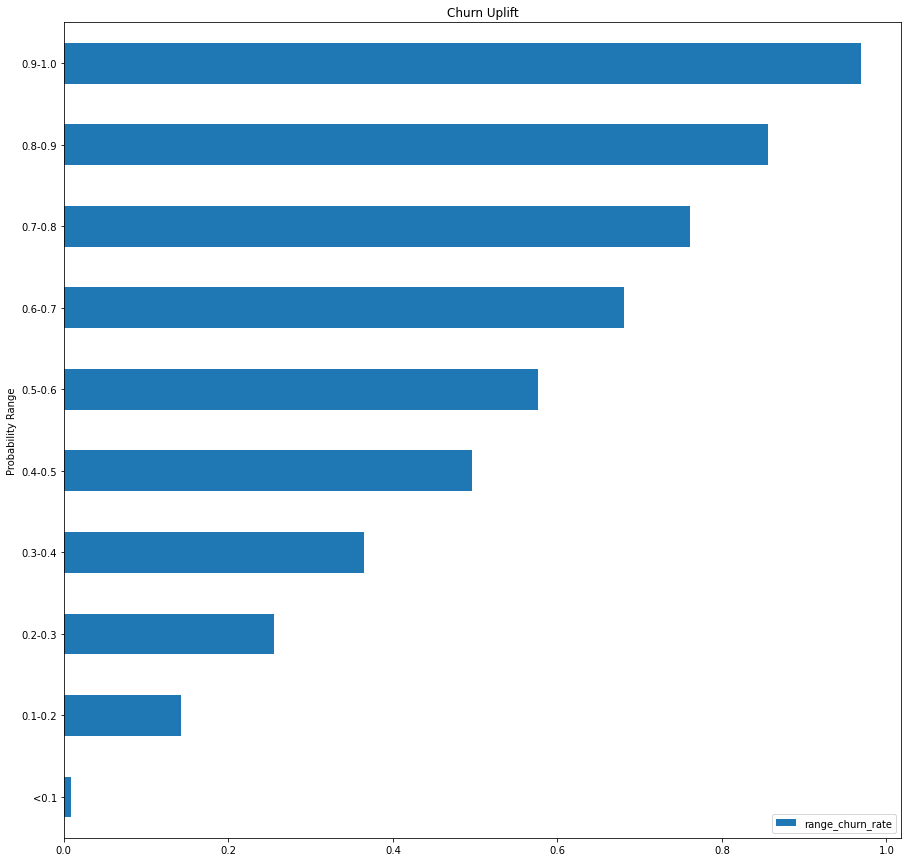

In [ ]:
churn_lift.plot.barh(x='churn_proba_range', y='range_churn_rate', figsize=[15,15], title='Churn Uplift', xlabel= 'Probability Range', ylabel='Churn Rate'  )

**The previous graph display the churn rate by range of modeled churn probability. We can appreciate that in the top ten percent probability of churning (0.9-1.0), our model can predict efficiently  the churn of 96% of the clients of this bin.**

In [ ]:
churn_lift.to_parquet('churn_lift.parquet.gzip', engine='pyarrow', compression='gzip')

### feature importance

In [ ]:
scores = final_model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('min_pmethod_renew', 696.8397021272232),
 ('max_transaction_month', 690.3835956151684),
 ('min_plan_days', 269.70791989599036),
 ('max_is_cancel', 236.46034720600915),
 ('max_plan_days', 162.1342720742914),
 ('mean_plan_days', 132.96634857194206),
 ('max_transaction_year', 96.52763075733263),
 ('std_pmethod_renew', 73.7021308119489),
 ('max_days_to_expire', 65.60333334953759),
 ('max_price_list', 56.49097194903336),
 ('std_price_list', 47.14023315614426),
 ('min_days_to_expire', 43.798638919750275),
 ('sum_pmethod_renew', 38.76239476721444),
 ('sum_plan_days', 27.074621909229172),
 ('max_transaction_day', 24.985124693310745),
 ('count_renew', 21.270551576496683),
 ('sum_payment_id', 19.574542632477108),
 ('min_amount_paid', 18.812316578170513),
 ('max_amount_paid', 18.353214953911262),
 ('max_pmethod_renew', 18.331144893389105),
 ('std_days_to_expire', 16.152636730569522),
 ('mean_pmethod_renew', 15.60157932068423),
 ('min_payment_id', 14.953144565769513),
 ('sum_price_list', 14.8467

In [ ]:
scores = final_model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('max_transaction_day', 6451),
 ('max_days_to_expire', 5144),
 ('std_days_to_expire', 4749),
 ('sum_days_to_expire', 3738),
 ('min_days_to_expire', 3583),
 ('mean_days_to_expire', 2933),
 ('registration_init_day', 2597),
 ('min_unq_ratio', 2234),
 ('std_unq_ratio', 2205),
 ('registration_init_month', 2052),
 ('sum_payment_id', 2038),
 ('sum_plan_days', 2037),
 ('std_skip50_ratio', 1944),
 ('std_skip985_ratio', 1942),
 ('mean_unq_ratio', 1903),
 ('std_skip_ratio', 1894),
 ('std_skip75_ratio', 1880),
 ('std_skip25_ratio', 1863),
 ('bd', 1743),
 ('min_total_secs', 1729),
 ('std_amount_paid', 1709),
 ('min_payment_id', 1615),
 ('city', 1607),
 ('mean_amount_paid', 1592),
 ('mean_payment_id', 1575),
 ('max_num_25', 1574),
 ('mean_skip985_ratio', 1519),
 ('mean_price_list', 1513),
 ('max_skip985_secs_ratio', 1486),
 ('std_payment_id', 1476),
 ('registration_init_year', 1461),
 ('mean_skip75_ratio', 1444),
 ('max_num_unq', 1417),
 ('sum_amount_paid', 1411),
 ('std_num_50', 1409),
 ('sum_skip

In [ ]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

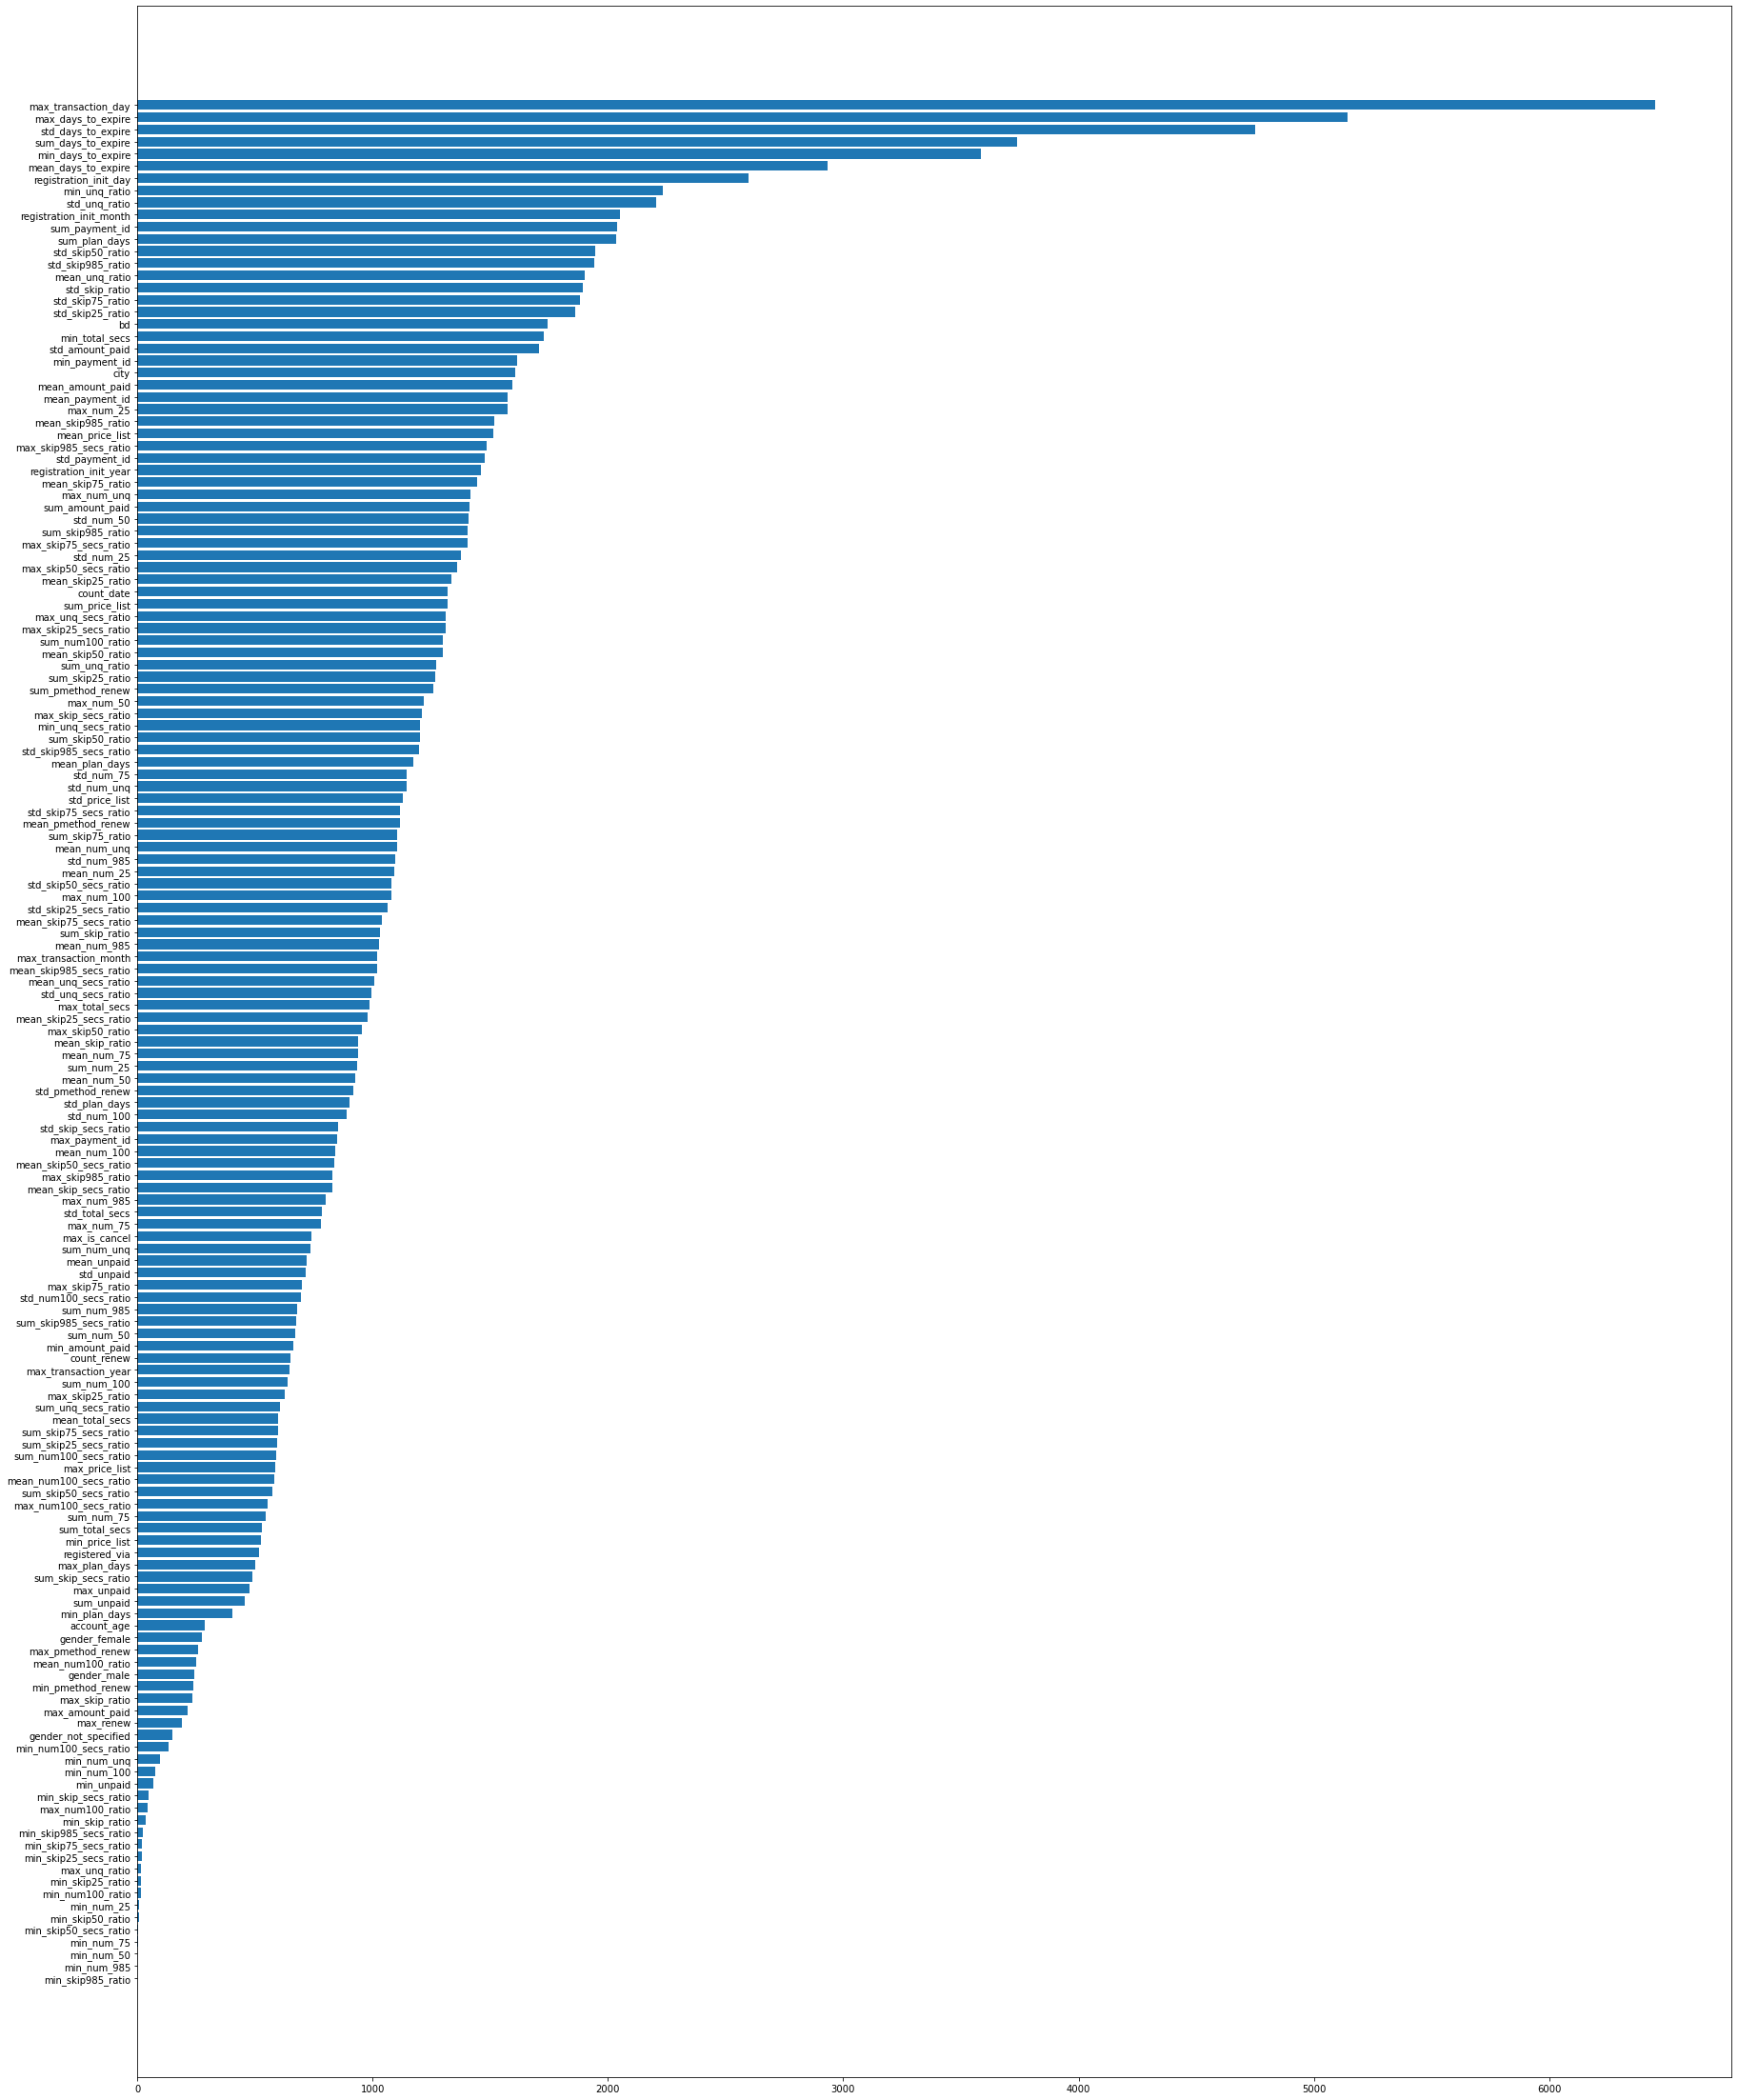

In [ ]:
plt.figure(figsize=(30, 40))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

In [ ]:
%%time
bins = [ 0,1, np.inf]
names = ['churned', 'not_churned']

y_test_fr['churn_label'] = pd.cut(y_test_fr['is_churn_x'], bins, labels=names)

display(y_test_fr.dtypes)

is_churn_x                             int64
PROBABILITY                          float32
msno                                  object
is_churn_y                             int64
city                                   int64
bd                                     int64
gender                              category
registered_via                         int64
registration_init_time        datetime64[ns]
min_payment_id                         int64
max_payment_id                         int64
mean_payment_id                      float64
std_payment_id                       float64
sum_payment_id                         int64
min_plan_days                          int64
max_plan_days                          int64
mean_plan_days                       float64
std_plan_days                        float64
sum_plan_days                          int64
min_price_list                         int64
max_price_list                         int64
mean_price_list                      float64
std_price_

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 11 ms


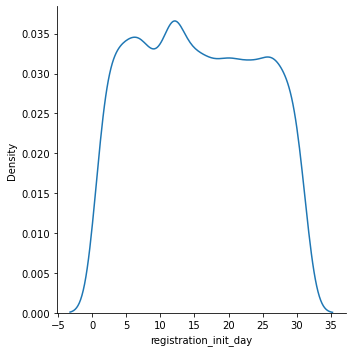

In [ ]:
sns.displot(y_test_fr[y_test_fr["churn_proba_range"] == "0.9-1.0" ], x="registration_init_day", kind="kde")

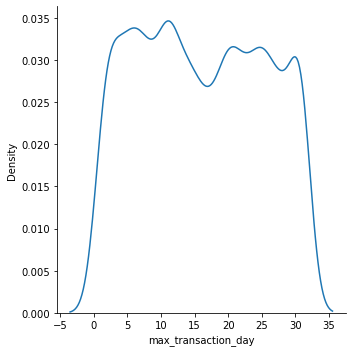

In [ ]:
sns.displot(y_test_fr[y_test_fr["churn_proba_range"] == "0.9-1.0" ], x="max_transaction_day", kind="kde")

In [ ]:
sns.displot(y_test_fr[y_test_fr["churn_proba_range"] == "0.9-1.0" ], x="min_unq_ratio", kind="kde")

In [ ]:
sns.displot(y_test_fr[y_test_fr["churn_proba_range"] == "0.9-1.0" ], x="mean_payment_id", kind="kde")

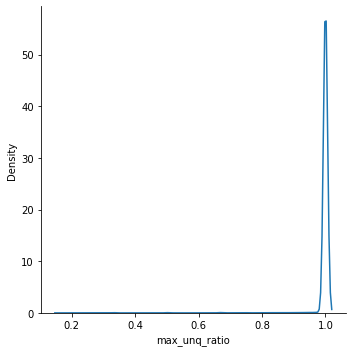

In [ ]:
sns.displot(y_test_fr[y_test_fr["churn_proba_range"] == "0.9-1.0" ], x="max_unq_ratio", kind="kde")

/home/reneh/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


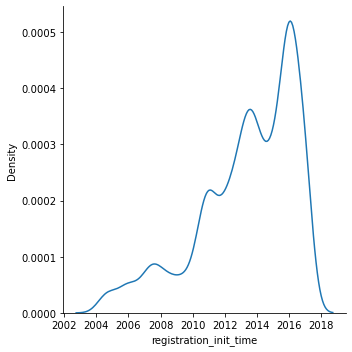

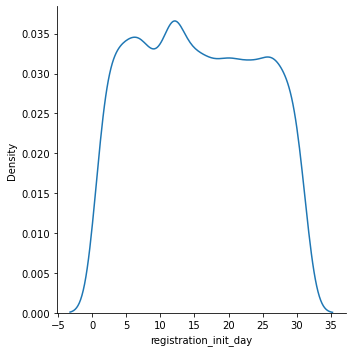

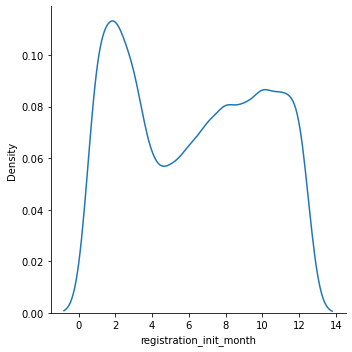

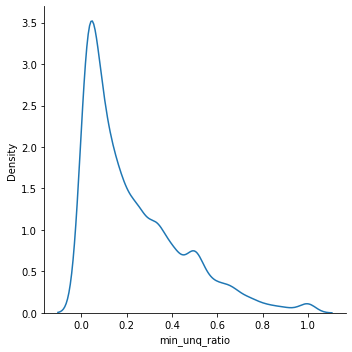

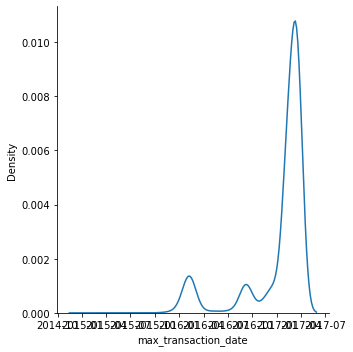

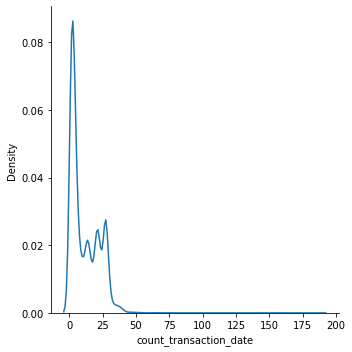

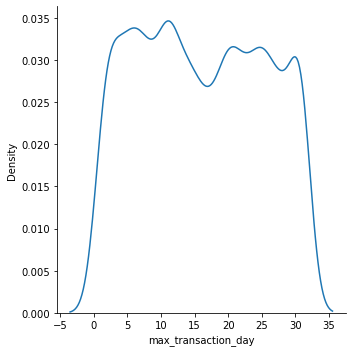

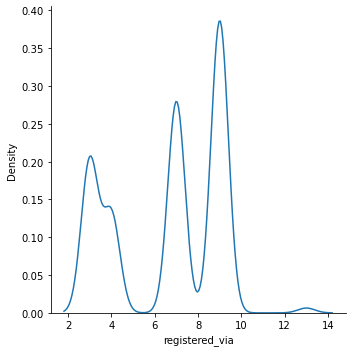

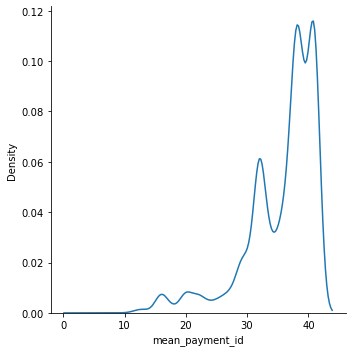

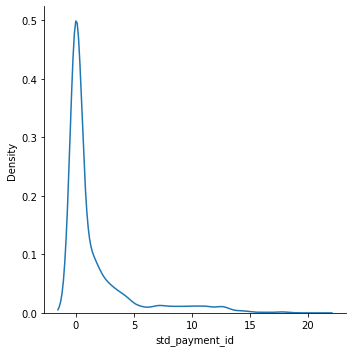

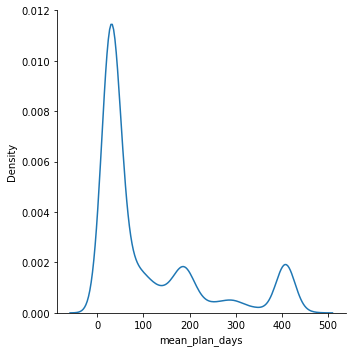

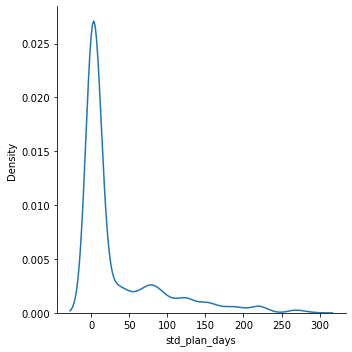

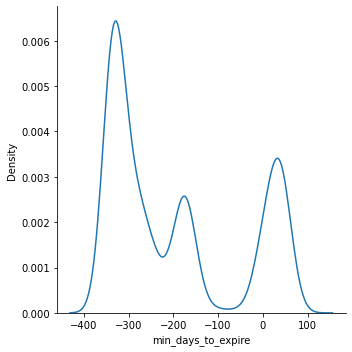

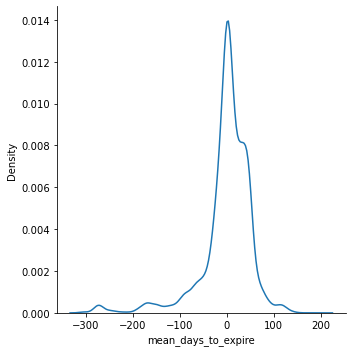

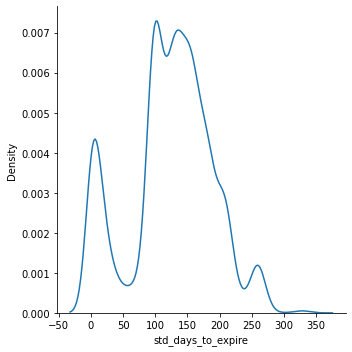

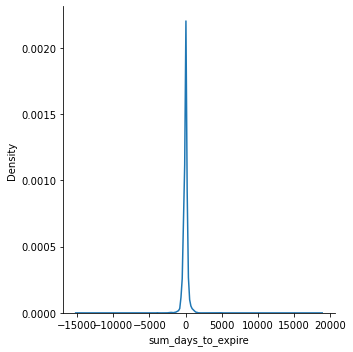

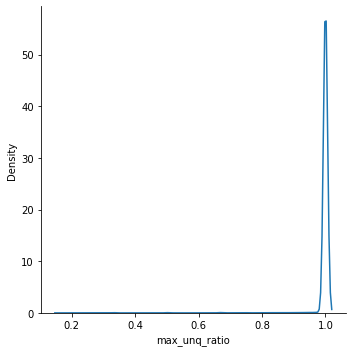

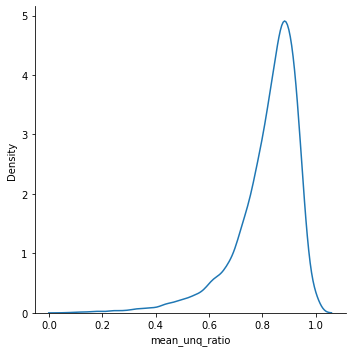

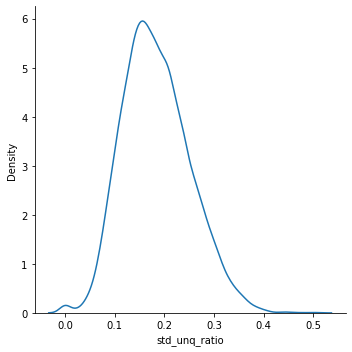

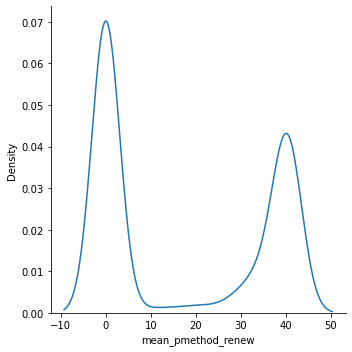

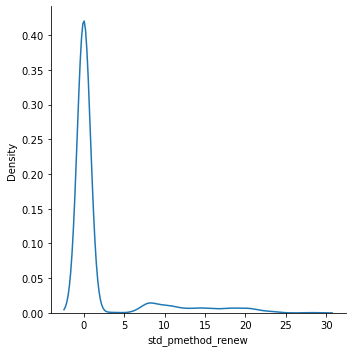

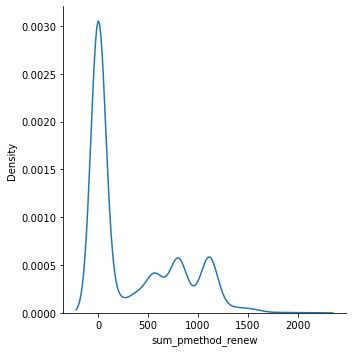

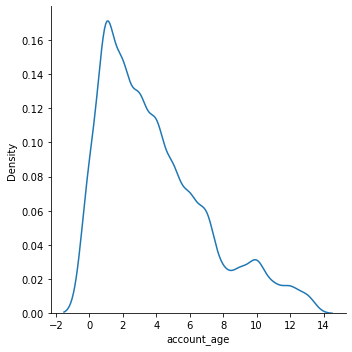

In [ ]:
col_list=['registration_init_time', 'registration_init_day', 'registration_init_month',
        'min_unq_ratio', 
        'min_transaction_date', 'max_transaction_date', 'count_transaction_date', 
        'max_transaction_day', 
        'registered_via', 
        'mean_payment_id', 'std_payment_id', 
        'min_plan_days', 'max_plan_days', 'mean_plan_days', 'std_plan_days', 'sum_plan_days',
        'min_days_to_expire', 'max_days_to_expire', 'mean_days_to_expire', 'std_days_to_expire', 
        'sum_days_to_expire', 
        'max_unq_ratio', 'mean_unq_ratio', 'std_unq_ratio', 'sum_unq_ratio',
        'min_pmethod_renew', 'max_pmethod_renew', 'mean_pmethod_renew', 'std_pmethod_renew', 
        'sum_pmethod_renew',
        'account_age']

for column in col_list:
    sns.displot(y_test_fr[y_test_fr["churn_proba_range"] == "0.9-1.0" ], x=column, kind="kde")

In [ ]:
%%time
import cudf

test_feautures = y_test_fr[y_test_fr["churn_proba_range"] == "0.9-1.0" ][['registration_init_time', 'registration_init_day', 'registration_init_month',
        'min_unq_ratio', 
        'min_transaction_date', 'max_transaction_date', 'count_transaction_date', 
        'max_transaction_day', 
        'registered_via', 
        'mean_payment_id', 'std_payment_id', 
        'min_plan_days', 'max_plan_days', 'mean_plan_days', 'std_plan_days', 'sum_plan_days',
        'min_days_to_expire', 'max_days_to_expire', 'mean_days_to_expire', 'std_days_to_expire', 
        'sum_days_to_expire', 
        'max_unq_ratio', 'mean_unq_ratio', 'std_unq_ratio', 'sum_unq_ratio',
        'min_pmethod_renew', 'max_pmethod_renew', 'mean_pmethod_renew', 'std_pmethod_renew', 
        'sum_pmethod_renew','account_age']]

test_features = cudf.DataFrame.from_pandas(test_feautures)

test_feautures.describe().T

CPU times: user 53.1 ms, sys: 16 ms, total: 69.1 ms
Wall time: 67.8 ms


count        mean         std           min  \
registration_init_day    8899.0   15.576582    8.725507      1.000000   
registration_init_month  8899.0    6.292730    3.686715      1.000000   
min_unq_ratio            8899.0    0.227621    0.214893      0.001439   
count_transaction_date   8899.0   11.496123   10.661439      1.000000   
max_transaction_day      8899.0   16.020901    9.257839      1.000000   
registered_via           8899.0    6.618721    2.449337      3.000000   
mean_payment_id          8899.0   35.582810    5.905346      3.000000   
std_payment_id           7947.0    1.574829    3.134103      0.000000   
min_plan_days            8899.0   80.215867  124.705280      0.000000   
max_plan_days            8899.0  148.929093  151.202717      1.000000   
mean_plan_days           8899.0  109.292329  123.624847      1.000000   
std_plan_days            7947.0   33.179858   55.749660      0.000000   
sum_plan_days            8899.0  557.591640  312.072707      1.000000   
min_days_to_expire       8899.0 -198.278234  146.956548   -359.000000   
max_days_to_expire       8899.0   85.463310   91.334639   -297.000000   
mean_days_to_expire      8899.0   -0.611054   55.381332   -306.000000   
std_days_to_expire       7947.0  124.454245   65.193281      0.000000   
sum_days_to_expire       8899.0    3.038094  450.994237 -14962.000000   
max_unq_ratio            8899.0    0.995975    0.040497      0.166667   
mean_unq_ratio           8899.0    0.818036    0.122774      0.057985   
std_unq_ratio            8798.0    0.183917    0.067171      0.000000   
sum_unq_ratio            8899.0  241.097857  194.494905      0.166667   
min_pmethod_renew        8899.0   13.256321   18.697953      0.000000   
max_pmethod_renew        8899.0   17.982582   19.753551      0.000000   
mean_pmethod_renew       8899.0   16.984764   19.080430      0.000000   
std_pmethod_renew        7947.0    1.811738    4.932329      0.000000   
sum_pmethod_renew        8899.0  350.191819  453.290766      0.000000   
account_age              8899.0    3.875379    3.117227      0.000000   

                                25%         50%         75%           max  
registration_init_day      8.000000   15.000000   23.000000     31.000000  
registration_init_month    3.000000    6.000000   10.000000     12.000000  
min_unq_ratio              0.055556    0.157303    0.333333      1.000000  
count_transaction_date     2.000000    7.000000   21.000000    187.000000  
max_transaction_day        8.000000   16.000000   24.000000     31.000000  
registered_via             4.000000    7.000000    9.000000     13.000000  
mean_payment_id           32.000000   38.000000   40.117647     41.000000  
std_payment_id             0.000000    0.000000    1.632993     20.506097  
min_plan_days              0.000000   30.000000   90.000000    450.000000  
max_plan_days             30.000000   31.000000  195.000000    450.000000  
mean_plan_days            29.142857   30.000000  173.303571    450.000000  
std_plan_days              0.000000    6.588952   42.426407    289.206674  
sum_plan_days            330.000000  573.000000  810.000000   1920.000000  
min_days_to_expire      -334.000000 -266.000000   -2.000000     84.000000  
max_days_to_expire        31.000000   51.000000  157.000000    364.000000  
mean_days_to_expire      -13.333333    4.178571   30.000000    198.000000  
std_days_to_expire        97.222862  130.824055  165.607026    342.946789  
sum_days_to_expire      -146.000000   30.000000  119.000000  18674.000000  
max_unq_ratio              1.000000    1.000000    1.000000      1.000000  
mean_unq_ratio             0.771565    0.849112    0.899834      1.000000  
std_unq_ratio              0.135922    0.178022    0.227431      0.503878  
sum_unq_ratio             61.463693  207.832751  387.212460    754.522010  
min_pmethod_renew          0.000000    0.000000   39.000000     41.000000  
max_pmethod_renew          0.000000    0.000000   41.000000     41.000000  
mean_pme